In [1]:
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import glob

In [2]:
#setting path to the env variable
folder = os.environ['CAPSTONE_DATA']
folder

'C:\\max\\Google Drive Max\\Max Shared\\Master Data Science\\2020-05 Capstone A\\msds_capstone\\data\\'

# EDA

## Loading

In [3]:
dataRaw= pd.read_pickle(os.path.join(folder,'tidy_data/Transactions_v4/Transactions.pkl'))
print(dataRaw.shape)
print(min(dataRaw['WeekDate']) , max(dataRaw['WeekDate']))
dataRaw.head(1)

(201730, 34)
2013-01-03 00:00:00 2019-12-26 00:00:00


WeekID  Year   WeekDate  Chain Master ID      Chain Master  \
0       1  2013 2013-01-03             1577  THE BARREL HOUSE   

  Category (CatMan)                        Product  Product ID Beverage Type  \
0     ECONOMY VODKA  MCCORMICK CHERRY VODKA 60  1L       82970       SPIRITS   

   ASW Product #  ... Alcohol Proof Qty Per Case Size Liters STD. Cases  \
0       34347348  ...          60.0           12         0.1        2.0   

  Dollar Sales 9L Cases Bottles Transactions Dollar Sales per Case  \
0       121.54     2.66    24.0            1                 60.77   

  Dollar Sales per 9L Case  
0                45.691729  

[1 rows x 34 columns]

In [4]:
def npFill(data):
    #https://stackoverflow.com/questions/9537543/replace-nans-in-numpy-array-with-closest-non-nan-value
    mask = np.isnan(data)
    data[mask] =np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), data[~mask])
    return(data)
    


### Filter by Category in Sup Premium Whiskey, Premium Vodka

In [5]:
data=dataRaw[dataRaw['Category (CatMan)'].isin(['SUP PREM WHISKEY','ECONOMY VODKA'])]
print(data.shape)
plt.style.use('default')
             

(19735, 34)


In [6]:
dataT = data.groupby(['Chain Master','Category (CatMan)','Product'])['WeekID'].nunique().sort_values(ascending=False)
t=dataT.groupby(level=[0,1],group_keys=False)
t2=t.apply(lambda x: x.sort_values(ascending=False).head(10)).reset_index()
t2['Product'].unique()[0:10]

# all chains in elpase, for category ['SUP PREM WHISKEY','ECONOMY VODKA'], all products, by week.



array(['TAAKA VODKA 80  1L', 'TAAKA VODKA 80 BLUE PET 375M',
       'TAAKA VODKA 80 PET 1.75L', 'DOBRA VODKA  1.75L',
       'TAAKA VODKA 80 PET 750M', 'MCCORMICK CHERRY VODKA 60  1L',
       'MCCORMICK APPLE VODKA 60  1L', 'TAAKA VODKA 80 BLUE PET 200M',
       'MCCORMICK GRAPE VODKA 60  1L', 'MCCORMICK APPLE VODKA 60  1.75L'],
      dtype=object)

# Qualitative Distribution

## Sales Transactions

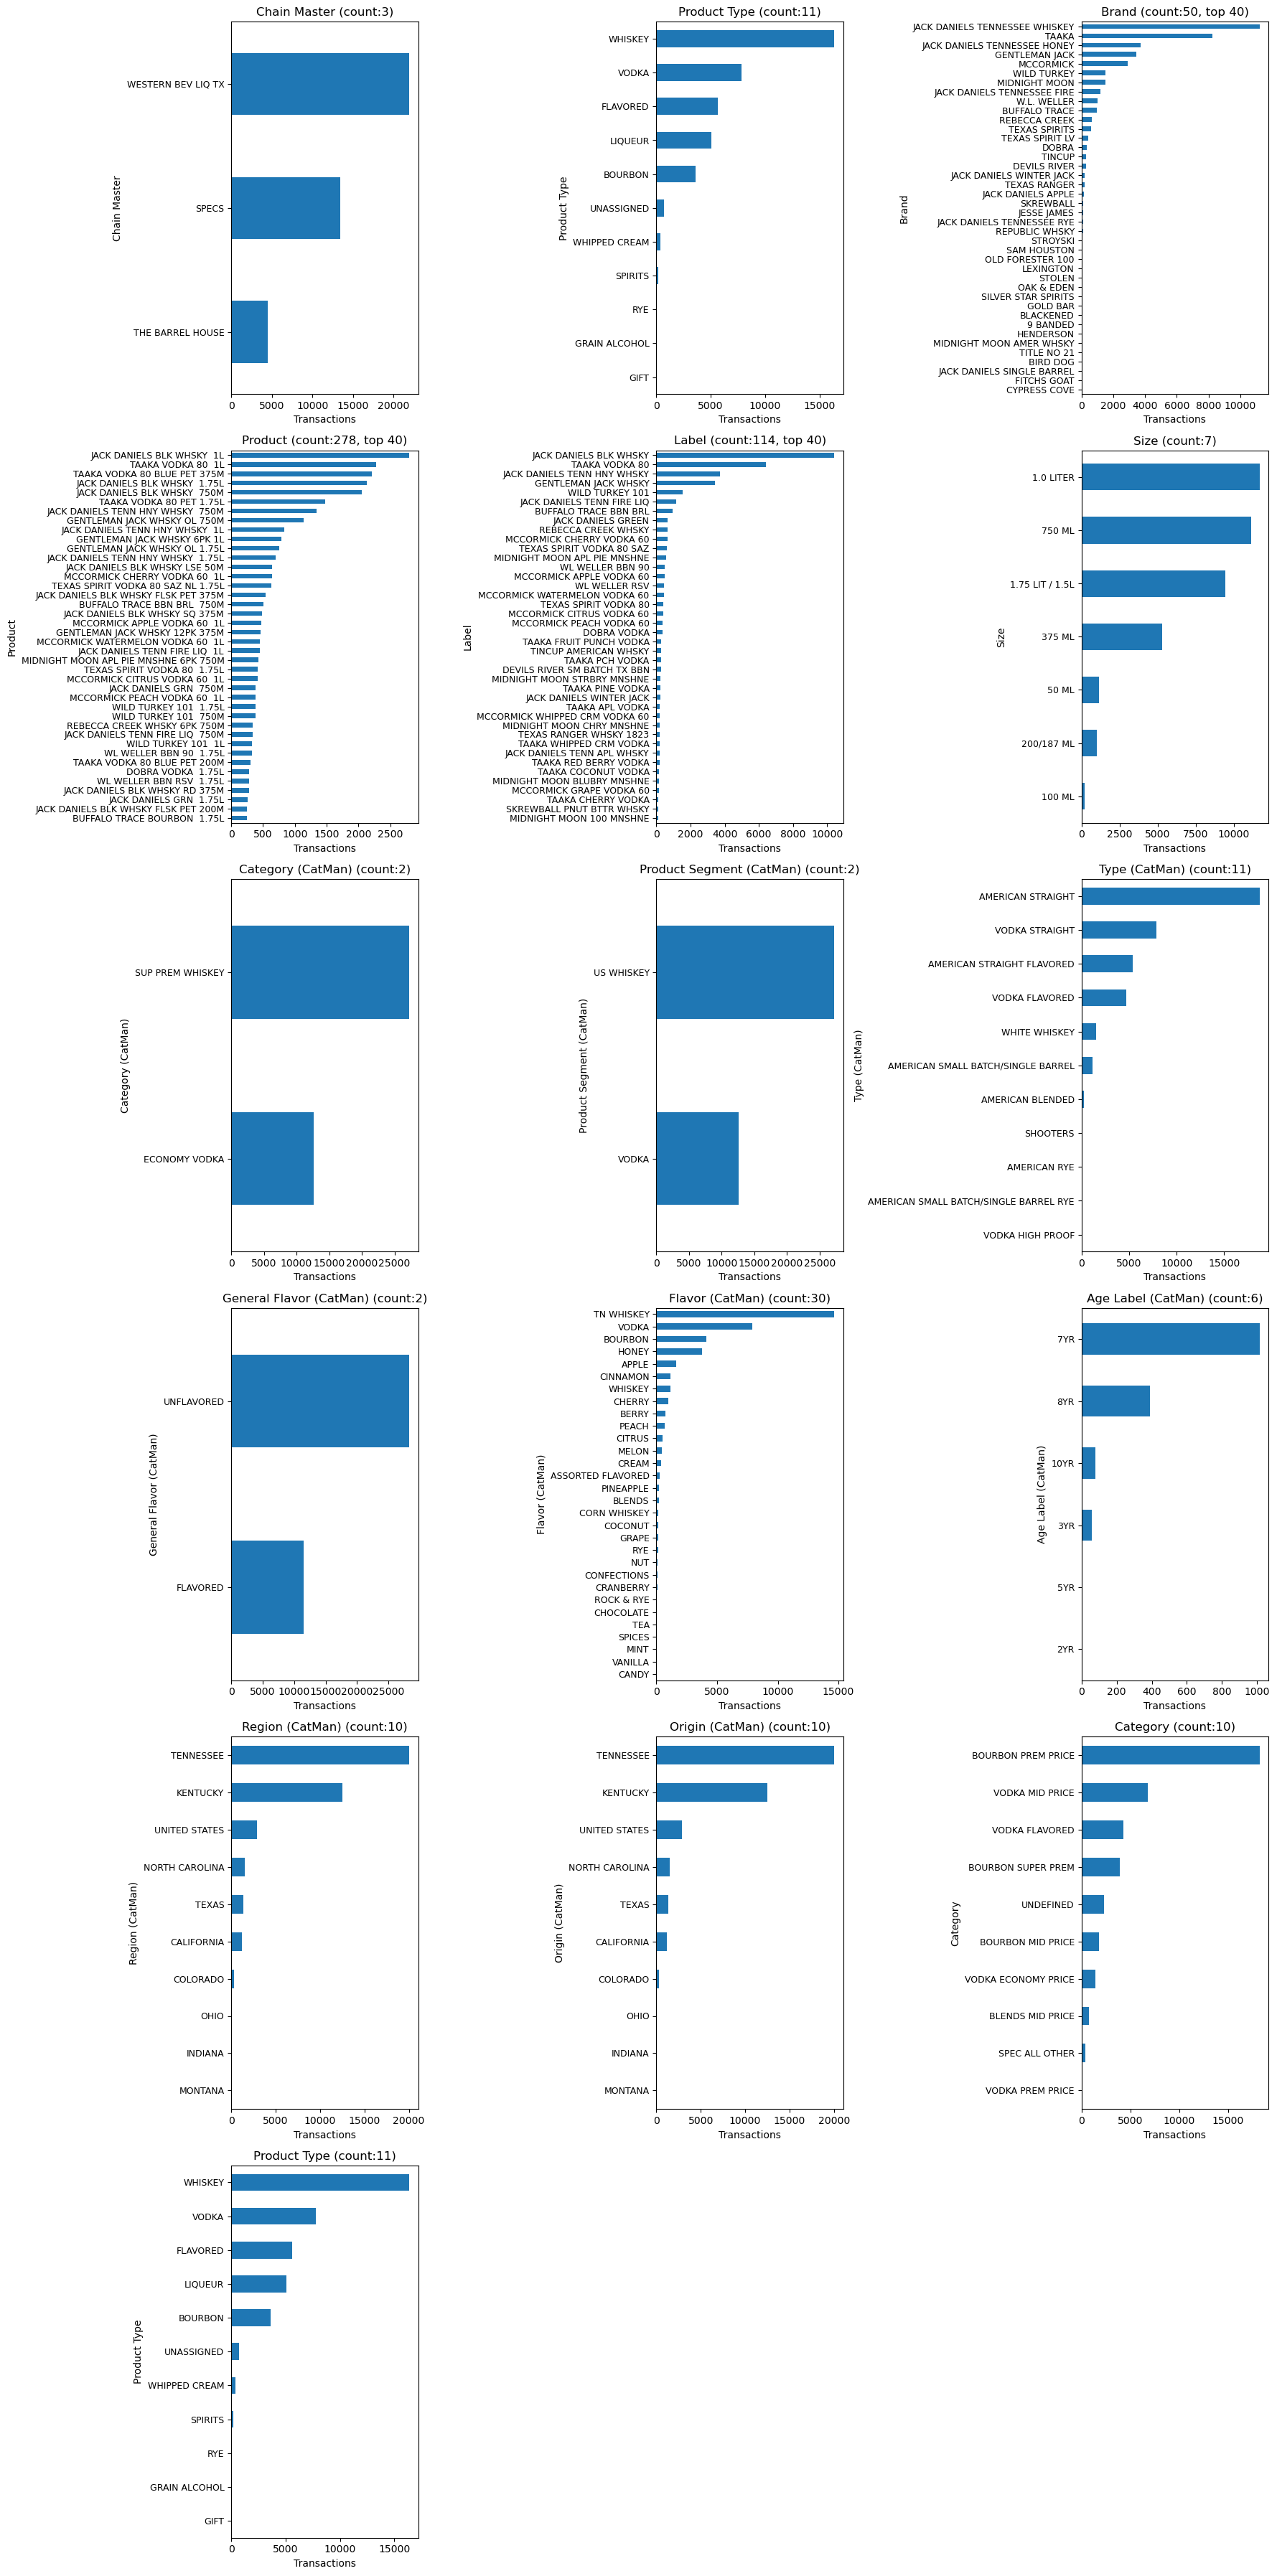

In [7]:
#cols = data.select_dtypes('object').columns
cols = ['Chain Master','Product Type','Brand','Product','Label','Size','Category (CatMan)'
        ,'Product Segment (CatMan)','Type (CatMan)','General Flavor (CatMan)','Flavor (CatMan)','Age Label (CatMan)'
        ,'Region (CatMan)','Origin (CatMan)'
        ,'Category','Product Type'

]

rows = math.ceil(len(cols)/3)
plt.figure(figsize=(18,6*rows))
maxOut = 40
for i,c in enumerate(cols):
    plt.subplot(rows,3,i+1)
    #v =  data[c].value_counts().sort_values(ascending=True)
    v= data.groupby(c)['Transactions'].sum().sort_values(ascending=True)
    plt.title(c + ' (count:' + str(v.shape[0]) + (', top ' + str(maxOut)  if v.shape[0]>maxOut else '' ) + ')')
    plt.tick_params(axis='y',labelsize=9)
    plt.xlabel('Transactions')
    v.tail(maxOut).plot(kind='barh')
plt.tight_layout()

## Sales 9L Cases

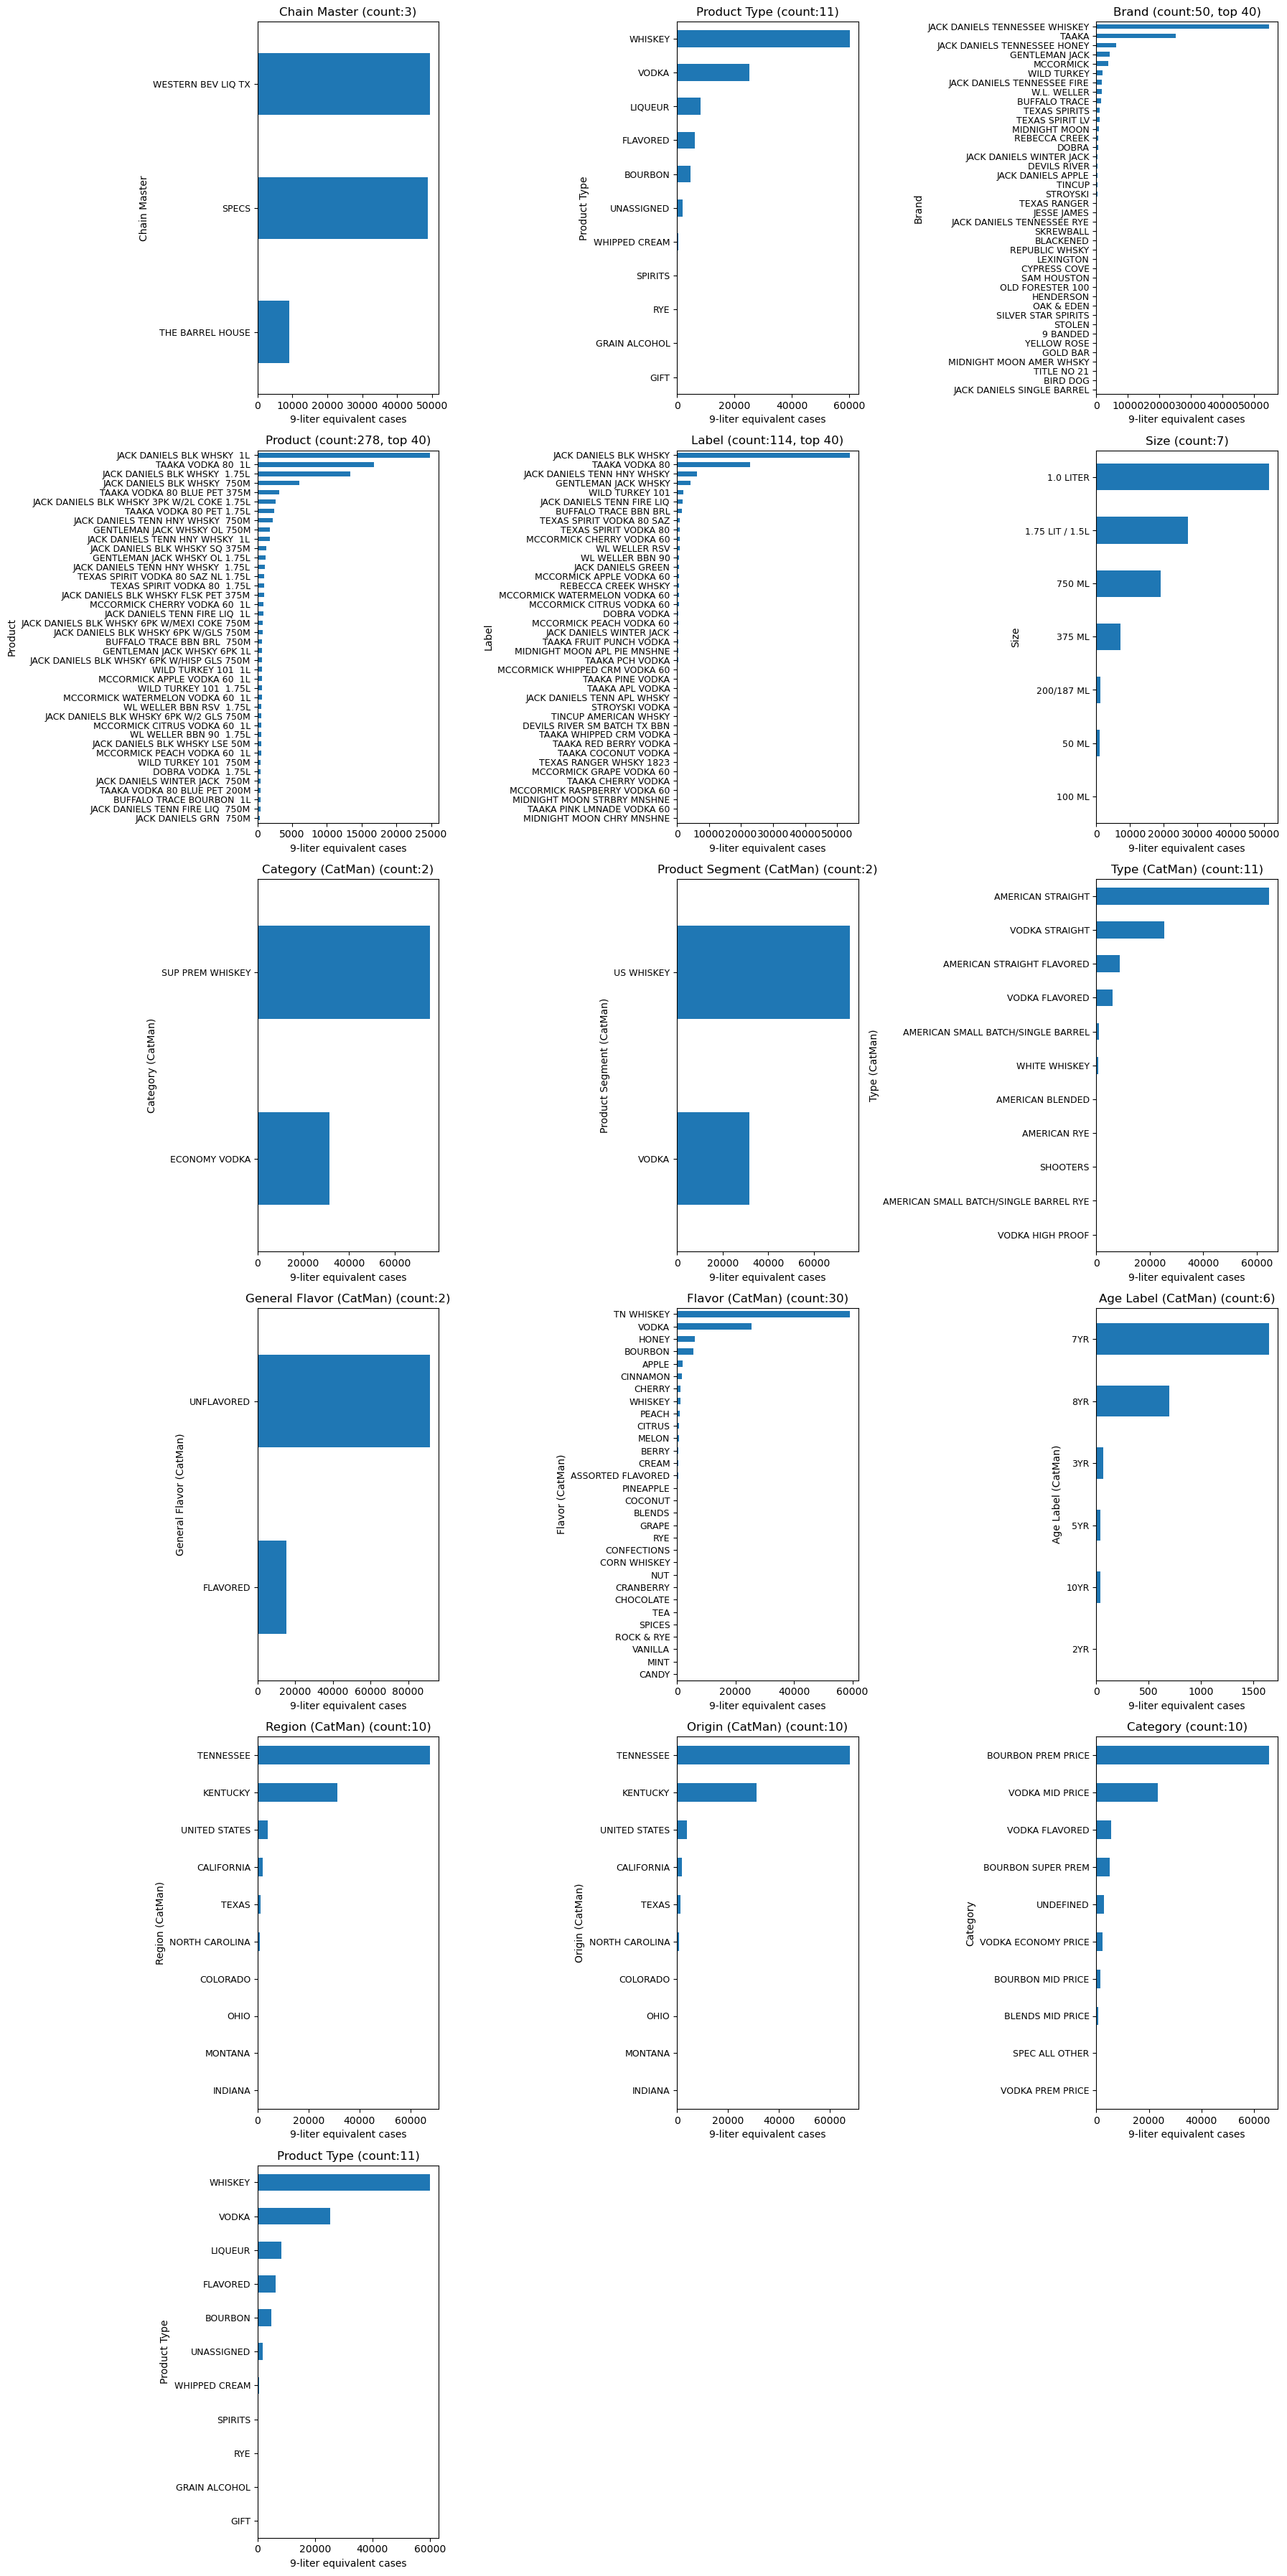

In [8]:
rows=math.ceil(len(cols)/3)
plt.figure(figsize=(18,6*rows))
maxOut = 40
for i,c in enumerate(cols):
    plt.subplot(rows,3,i+1)
    v =  data.groupby(c)['9L Cases'].sum().sort_values(ascending=True)
    plt.title(c + ' (count:' + str(v.shape[0]) + (', top ' + str(maxOut)  if v.shape[0]>maxOut else '' ) + ')')
    plt.tick_params(axis='y',labelsize=9)
    plt.xlabel('9-liter equivalent cases')
    v.tail(maxOut).plot(kind='barh')
plt.tight_layout()

# Qualitative Distributions

## by Qualitative Column

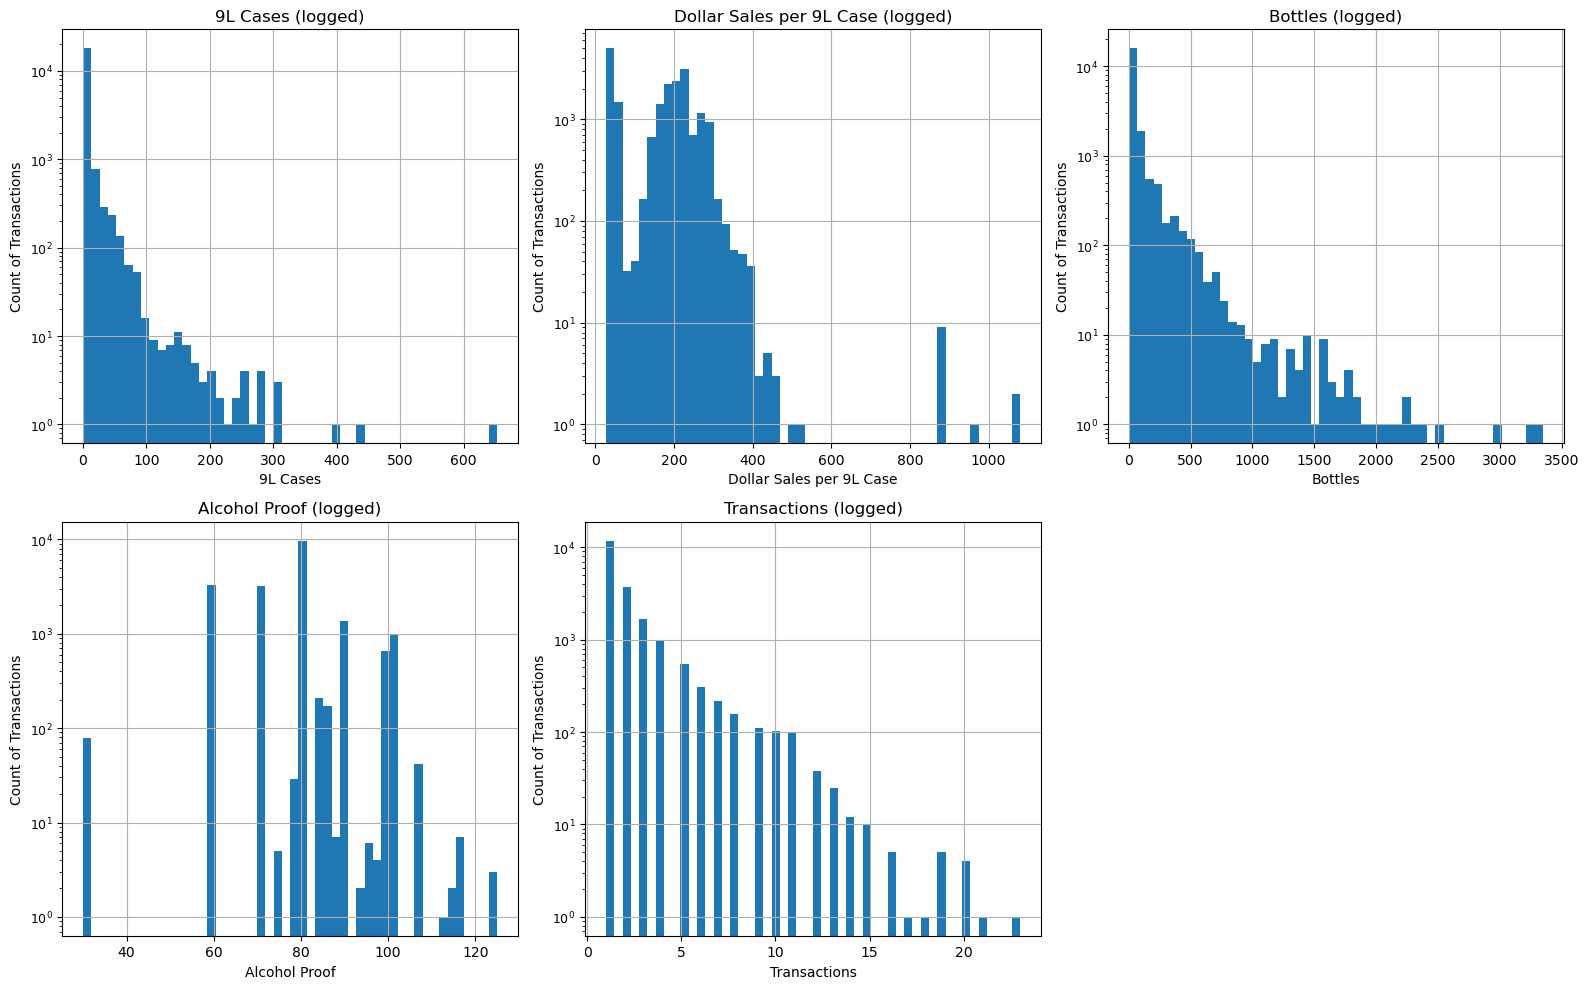

In [9]:
#cols = data.select_dtypes('object').columns
import seaborn as sns
cols = ['9L Cases','Dollar Sales per 9L Case','Bottles','Alcohol Proof','Transactions']
rows = math.ceil(len(cols)/3)
plt.figure(figsize=(16,5*rows))
for i,c in enumerate(cols):
    plt.subplot(rows,3,i+1)
    plt.title(c + ' (logged)')
    plt.tick_params(axis='y',labelsize=9)
    data[data[c]!=-99999][c].hist(bins=50)
    #sns.distplot(data[c],bins=50,kde=False)
    plt.yscale(value='log')
    plt.xlabel(c)
    plt.ylabel('Count of Transactions')
    
plt.tight_layout()

## Top Products

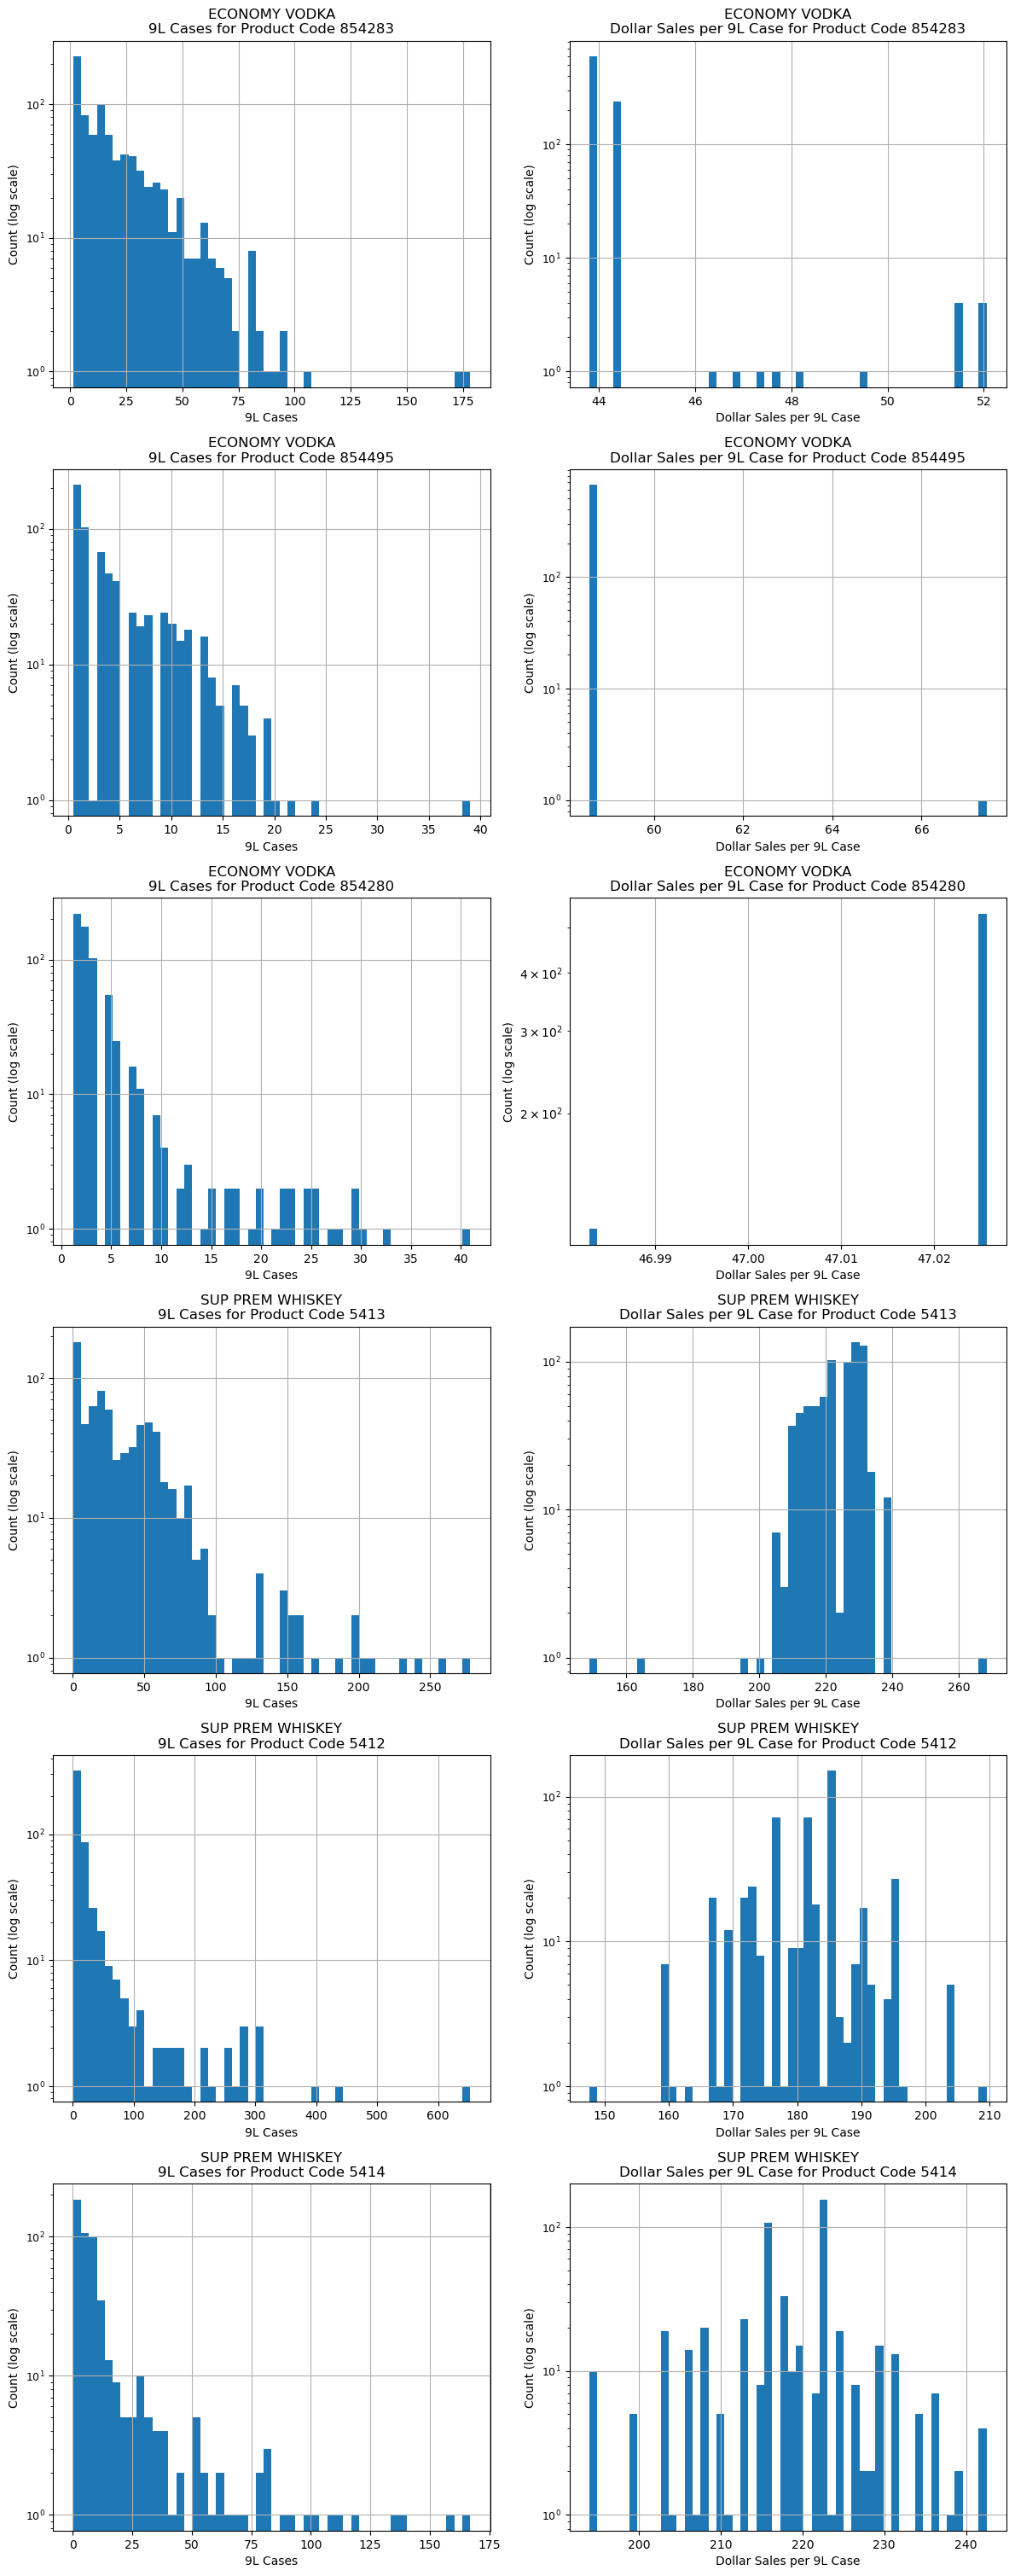

In [10]:
#cols = data.select_dtypes('object').columns
import seaborn as sns
cols = ['9L Cases','Dollar Sales per 9L Case']
topN=3
cats = data['Category (CatMan)'].unique()
rows = math.ceil(len(cols)*topN*len(cats))
plt.figure(figsize=(12,5*rows))
for icat,cat in enumerate(cats):
    topProds = (data[data['Category (CatMan)'] == cat]
            .groupby('Product ID')['9L Cases']
            .sum()
            .sort_values(ascending=False)
            .head(topN)
            .index.values)
    for ip,p in enumerate(topProds):
        for i,c in enumerate(cols):
            plt.subplot(rows,len(cols),i+(ip*len(cols)) + (icat*len(cols)*topN)+1)
            plt.title( cat + '\n'+c + ' for Product Code ' + str(p) )
            plt.tick_params(axis='y',labelsize=9)
            data[(data['Product ID'] == p) & (data[c]!=-99999)][c].hist(bins=50)
            #sns.distplot(data[c],bins=50,kde=False)
            plt.yscale(value='log')
            plt.xlabel(c)
            plt.ylabel('Count (log scale)')

plt.tight_layout()

## Top Producs Violin Chart

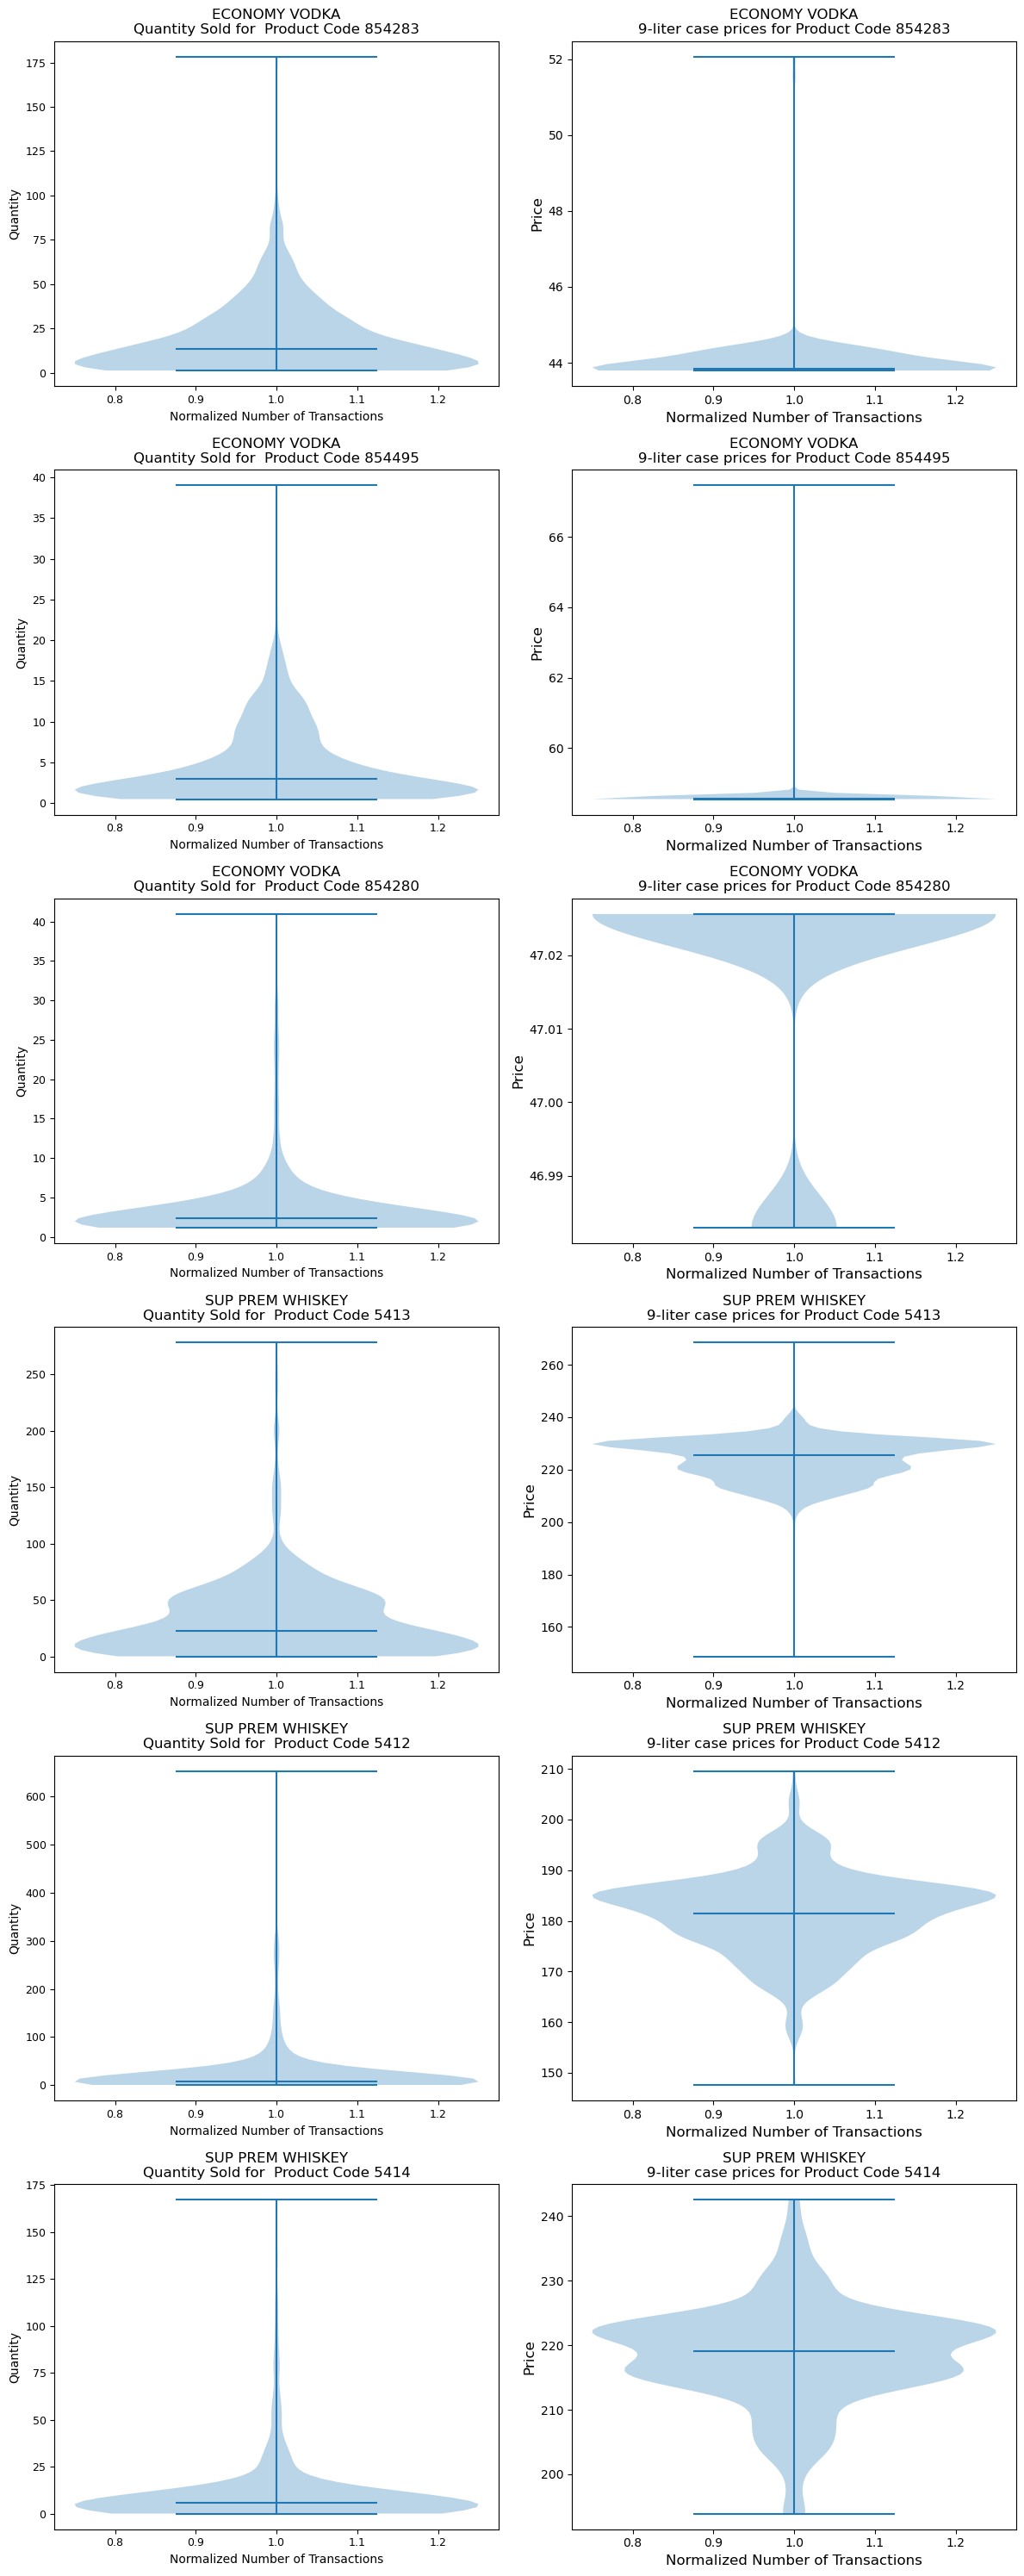

In [11]:
#cols = data.select_dtypes('object').columns
import seaborn as sns
price = 'Dollar Sales per 9L Case'
qty = '9L Cases'
topN=3
cats = data['Category (CatMan)'].unique()
rows = math.ceil(len(cats)*topN)
(fig,axs) = plt.subplots(rows,2,figsize=(12,5*rows))
for icat,cat in enumerate(cats):
    topProds = (data[data['Category (CatMan)'] == cat]
            .groupby('Product ID')['9L Cases']
            .sum()
            .sort_values(ascending=False)
            .head(topN)
            .index.values)
    for ip,p in enumerate(topProds):
        ax1= axs[ip + (icat*topN),0]
        ax1.set_title( cat + '\nQuantity Sold for  Product Code ' + str(p) )
        dqty=data[(data['Product ID'] == p)][qty]
        ax1.violinplot(dqty,showmeans=False,showextrema=True, showmedians=True,vert=True)
        ax1.tick_params(axis='y',labelsize=9)
        ax1.tick_params(axis='x',labelsize=9)
        ax1.set_ylabel('Quantity')
        ax1.set_xlabel('Normalized Number of Transactions')
        ##
        ax2= axs[ip + (icat*topN),1]
        ax2.set_title( cat + '\n9-liter case prices for Product Code ' + str(p) )
        dpr=data[(data['Product ID'] == p)][price]
        ax2.violinplot(dpr,showmeans=False,showextrema=True, showmedians=True,vert=True)
        ax2.tick_params(axis='y',labelsize=10)
        ax2.tick_params(axis='x',labelsize=10)
        ax2.set_ylabel('Price',size=12)
        ax2.set_xlabel('Normalized Number of Transactions',size=12)

plt.tight_layout()

## Trends by Week

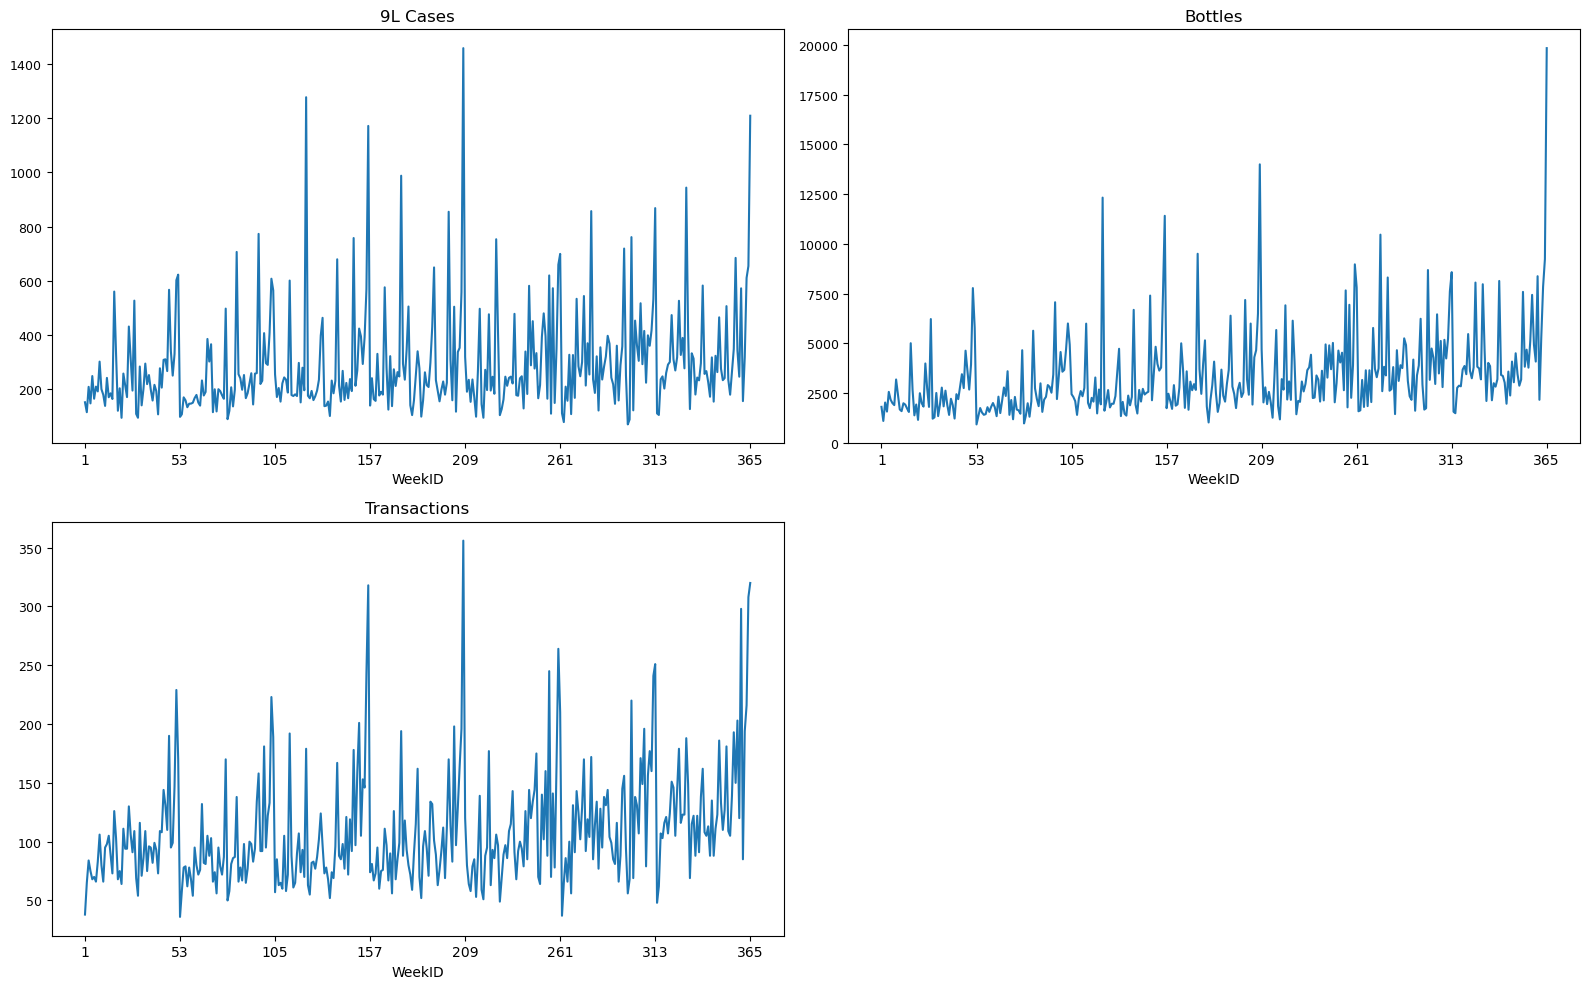

In [12]:
#cols = data.select_dtypes('object').columns
import seaborn as sns
cols = ['9L Cases','Bottles','Transactions']
rows = math.ceil(len(cols)/2)
plt.figure(figsize=(16,5*rows))
for i,c in enumerate(cols):
    plt.subplot(rows,2,i+1)
    plt.title(c)
    plt.tick_params(axis='y',labelsize=9)
    plt.xticks(np.arange(min(data['WeekID']), max(data['WeekID'])+1, 52.0))
    d=data.groupby(by=['WeekID'])[c].sum()
    d.plot()
plt.tight_layout()

## Top Products


### Weekly

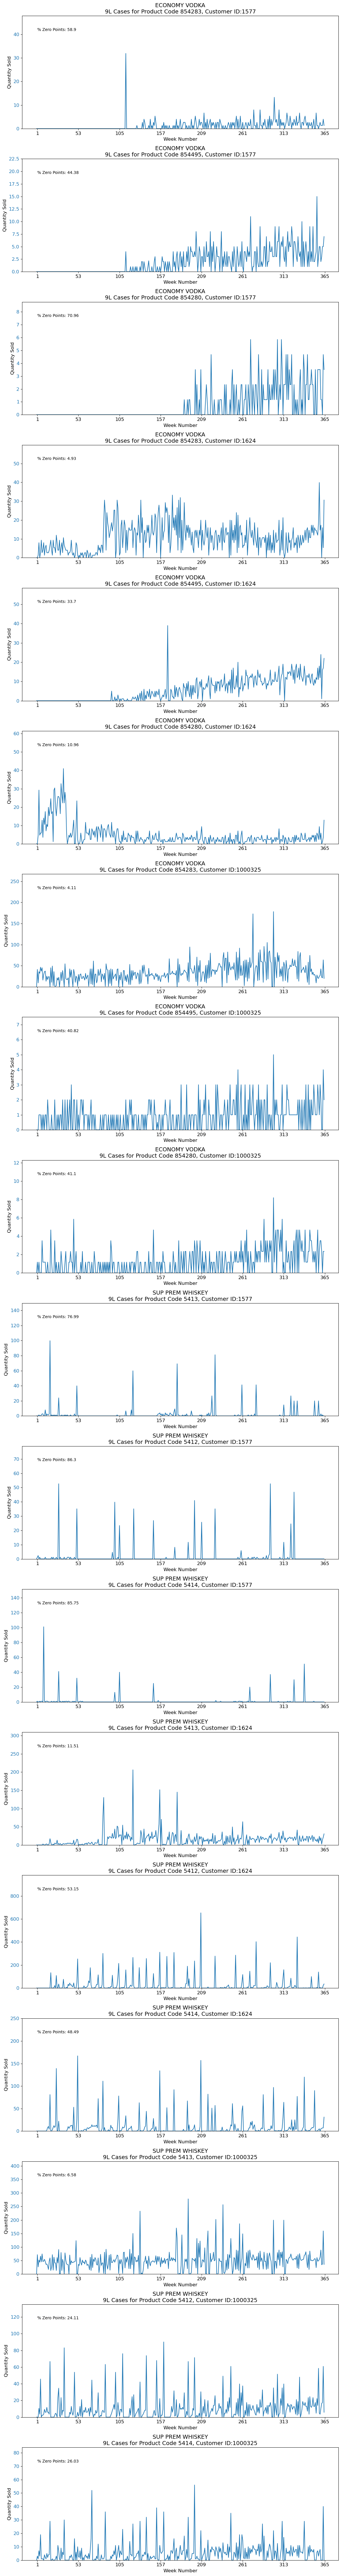

In [51]:
#cols = data.select_dtypes('object').columns
import seaborn as sns

    
col = '9L Cases'
topN = 3
cats = data['Category (CatMan)'].unique() 
chains = data['Chain Master ID'].unique() 
price = 'Dollar Sales per 9L Case'
rows = topN*len(cats)*len(chains)
fig,ax = plt.subplots(nrows=topN*len(cats)*len(chains),figsize=(12,5*rows))
wks=np.arange(0,max(data['WeekID']))
for icat,cat in enumerate(cats):
    topProds = (data[data['Category (CatMan)'] ==cat]
            .groupby('Product ID')['9L Cases']
            .sum()
            .sort_values(ascending=False)
            .head(topN)
            .index.values)
    for ich,ch in enumerate(chains):
        for ip,p in enumerate(topProds):
            #plt.subplot(rows,1,ip+icat*topN+1)
            axr = ip + icat*topN*len(chains) + ich*topN
            ax[axr].set_title(cat + '\n' + col + ' for Product Code ' + str(p) + ', Customer ID:' + str(ch),size=14)
            ax[axr].tick_params(axis='y',labelsize=12)
            ax[axr].tick_params(axis='x',labelsize=12)
            ax[axr].set_xticks(np.arange(min(data['WeekID']), max(data['WeekID'])+1, 52.0))
            ax[axr].set_xlabel('Week Number')

            color = 'tab:blue'
            q=data[(data['Product ID'] == p) & (data[c]!=-99999) & (data['Chain Master ID']==ch) ].groupby(by=['WeekID'])[col].sum()
            q=q.reindex(wks,fill_value=0)
            qZeroes = round(q[q==0].shape[0] / q.shape[0]*100,2)
            ax[axr].text(1,max(q)*1.3,"% Zero Points: " + str(qZeroes))
            ax[axr].plot(q,label='Quantity',color=color)#,ylim=(0,max(q)*1.5))
            ax[axr].set_xlabel('Week Number',size=12)
            ax[axr].set_ylabel('Quantity Sold',size=12)
            ax[axr].set_ylim(0,max(q)*1.5)
            ax[axr].tick_params(axis='y', labelcolor=color)
            #ax[axr].legend()
        
plt.tight_layout()

### by Month

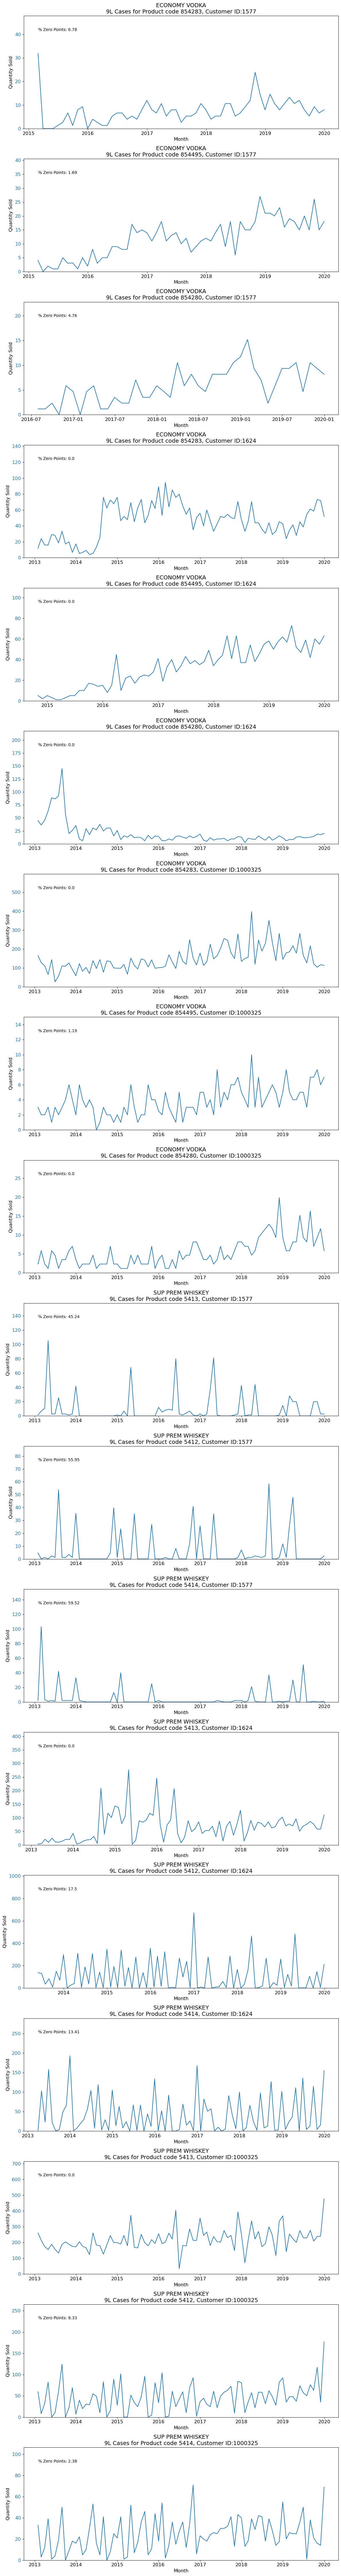

In [52]:
#cols = data.select_dtypes('object').columns
import seaborn as sns

    
col = '9L Cases'
topN = 3
cats = data['Category (CatMan)'].unique() 
chains = data['Chain Master ID'].unique() 
price = 'Dollar Sales per 9L Case'
fig,ax = plt.subplots(nrows=topN*len(cats)*len(chains),figsize=(12,5*rows))
wks=np.arange(0,max(data['WeekID']))
for icat,cat in enumerate(cats):
    topProds = (data[data['Category (CatMan)'] ==cat]
            .groupby('Product ID')['9L Cases']
            .sum()
            .sort_values(ascending=False)
            .head(topN)
            .index.values)
    for ich,ch in enumerate(chains):
        for ip,p in enumerate(topProds):
            #plt.subplot(rows,1,ip+icat*topN+1)
            axr = ip + icat*topN*len(chains) + ich*topN
            ax[axr].set_title(cat + '\n' + col + ' for Product code ' + str(p) + ', Customer ID:' + str(ch),size=14)
            ax[axr].tick_params(axis='y',labelsize=12)
            ax[axr].tick_params(axis='x',labelsize=12)
            ax[axr].set_xlabel('Week Number')
            color = 'tab:blue'
            q=(data[(data['Product ID'] == p) & (data[c]!=-99999) & (data['Chain Master ID']==ch) ]
               .groupby(by=[pd.Grouper(key='WeekDate',freq='M')])
               [col].sum())
            #q=q.reindex(wks,fill_value=0)
            qZeroes = round(q[q==0].shape[0] / q.shape[0]*100,2)
            ax[axr].text(min(q.index),max(q)*1.3,"% Zero Points: " + str(qZeroes))

            ax[axr].plot(q,label='Quantity',color=color)#,ylim=(0,max(q)*1.5))
            ax[axr].set_xlabel('Month',size=12)
            ax[axr].set_ylabel('Quantity Sold',size=12)
            ax[axr].set_ylim(0,max(q)*1.5)
            ax[axr].tick_params(axis='y', labelcolor=color)
            #ax[axr].set_xticks(np.arange(min(data['WeekID']), max(data['WeekID'])+1, 52.0))
            #ax[axr].legend()
        
plt.tight_layout()

## Price and Qty by Month

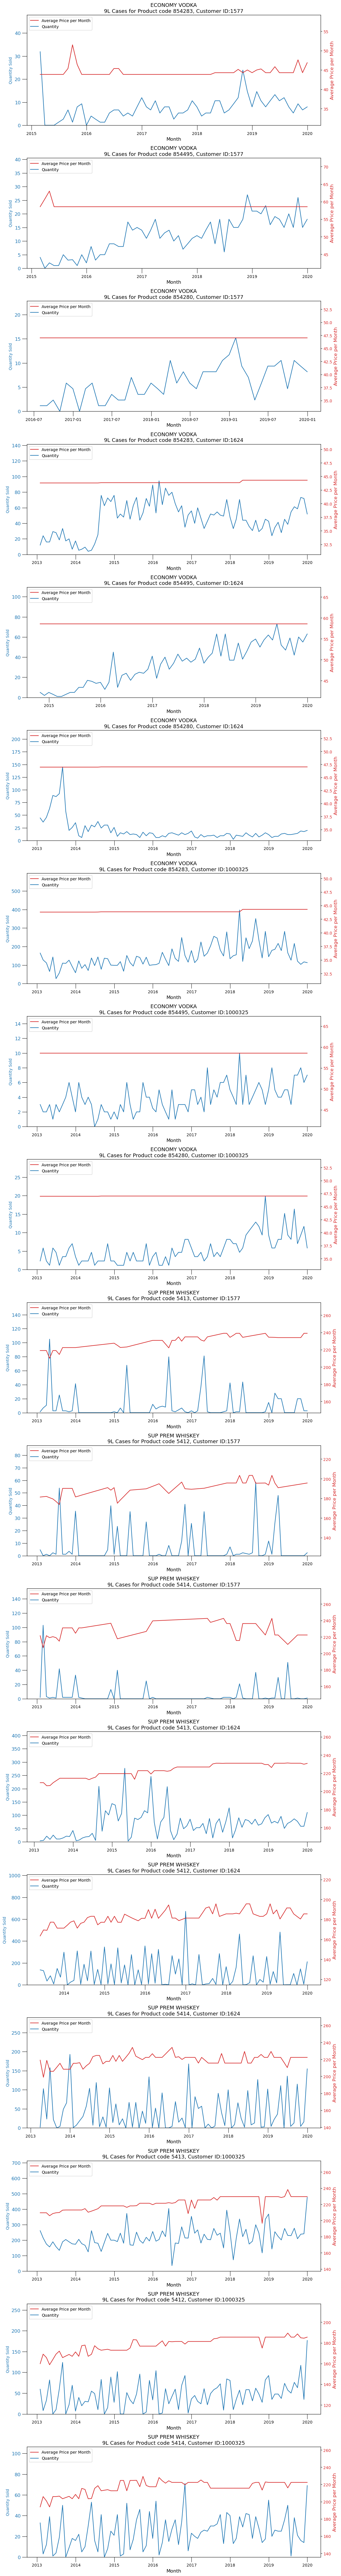

In [17]:
#cols = data.select_dtypes('object').columns
import seaborn as sns

    
col = '9L Cases'
topN = 3
cats = data['Category (CatMan)'].unique() 
price = 'Dollar Sales per 9L Case'
chains = data['Chain Master ID'].unique() 
qty = '9L Cases'
rows = topN*len(cats)*len(chains)
fig,ax = plt.subplots(nrows=rows,figsize=(12,5*rows))
wks=np.arange(1,max(data['WeekID']))
for icat,cat in enumerate(cats):
    topProds = (data[data['Category (CatMan)'] ==cat]
            .groupby('Product ID')['9L Cases']
            .sum()
            .sort_values(ascending=False)
            .head(topN)
            .index.values)
    for ich,ch in enumerate(chains):
        for ip,p in enumerate(topProds):
            #plt.subplot(rows,1,ip+icat*topN+1)
            axr = ip+icat*topN*len(chains) + ich*topN
            ax[axr].set_title(cat + '\n' + col + ' for Product code ' + str(p) + ', Customer ID:' + str(ch),size=13)
            ax[axr].tick_params(axis='y',labelsize=12)
            #ax[axr].set_xticks(np.arange(min(data['WeekID']), max(data['WeekID'])+1, 52.0))
            ax[axr].set_xlabel('Week Number')

            color = 'tab:blue'

            q=(data[(data['Product ID'] == p) & (data[c]!=-99999) & (data['Chain Master ID']==ch) ]
                   .groupby(by=[pd.Grouper(key='WeekDate',freq='M')])
                   [qty].sum())

            #q=data[(data['Product ID'] == p) ].groupby(by=['WeekID'])[qty].sum()
            ax[axr].plot(q,label='Quantity',color=color)#,ylim=(0,max(q)*1.5))
            ax[axr].set_xlabel('Month',size=12)
            ax[axr].set_ylabel('Quantity Sold',color=color)
            ax[axr].set_ylim(0,max(q)*1.5)
            ax[axr].tick_params(axis='y', labelcolor=color,size=12)
            ax[axr].tick_params(axis='x',size=12)
            #ax[axr].legend()

            ax2 = ax[axr].twinx()
            color = 'tab:red'
            pr=(data[(data['Product ID'] == p) & (data[c]!=-99999) & (data['Chain Master ID']==ch) ]
                .groupby(by=[pd.Grouper(key='WeekDate',freq='M')])
                .apply(lambda x: pd.Series({
                    price:sum(x[price]*x[qty])/sum(x[qty]) if sum(x[qty]) != 0 else np.nan
                }))
               )
            pr[price] = npFill(pr[price])

                
            #pr=data[(data['Product ID'] == p)].groupby(by=['WeekID']).apply(lambda x: pd.Series({price:sum(x[price]*x[qty])/sum(x[qty])}))
            #wks=np.arange(1,max(data['WeekID']))
            p2=ax2.plot(pr,label='Average Price per Month',color=color)#,ylim=(0,max(p)*1.1))
            ax2.set_ylim(min(pr[price])*.70,max(pr[price])*1.15)
            ax2.set_ylabel('Average Price per Month',color=color,size=12)
            ax2.tick_params(axis='y', labelcolor=color)
            #ax2.legend()
            h1, l1 = ax[axr].get_legend_handles_labels()
            h2, l2 = ax2.get_legend_handles_labels()
            ax[axr].legend(h2+h1, l2+l1, loc=2)
        
plt.tight_layout()

## Counting Products by Week

73

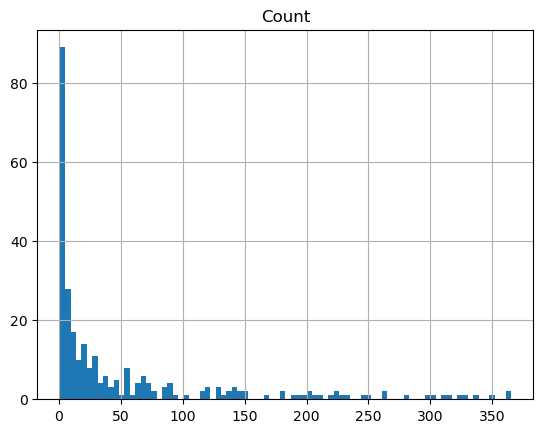

In [18]:
plt.style.use('default')
t=data.groupby(['Product'])['WeekID'].agg(Count='nunique').sort_values(by='Count',ascending=False)
t.hist(bins=84)
sum(t['Count']>=60)

# Price Analysis

## Distribution of Price Mean and Std per Product

<Figure size 1000x500 with 0 Axes>

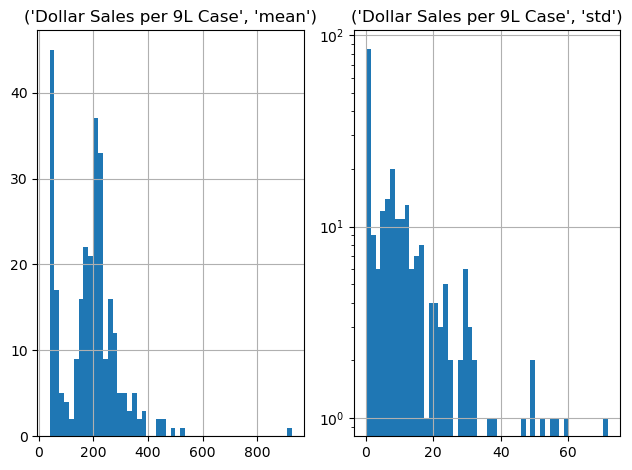

In [19]:

products = data.groupby('Product').agg({'Dollar Sales per 9L Case':[np.mean,np.std]})
plt.figure(figsize=(10,5))
products.hist(bins=50)
plt.yscale(value='log')
plt.tight_layout()           
           

## Price Mean and Variance by Week (Normalized)

### Top Products

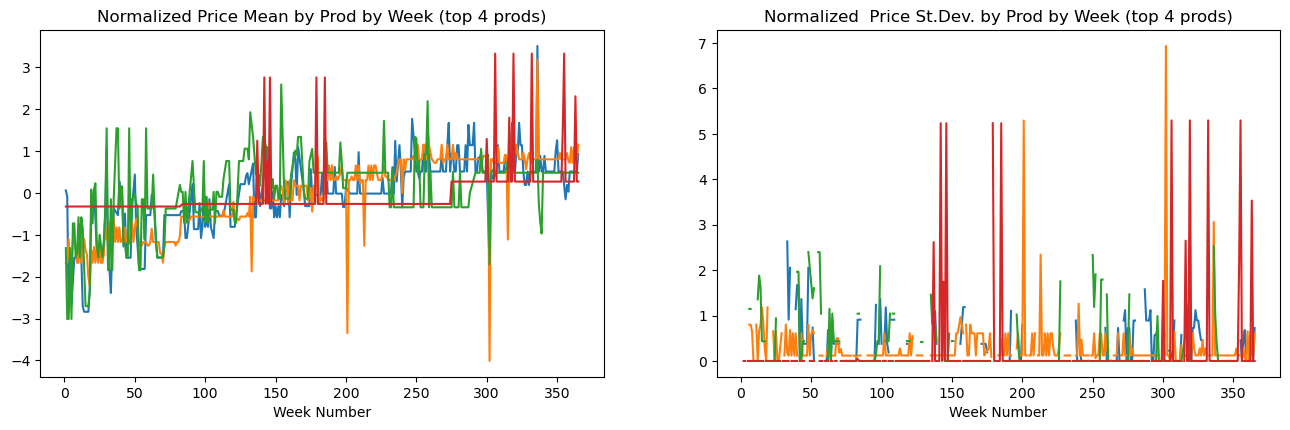

Product  WeekID  Price9LMean  Price9LStd  ProductID
616   JACK DANIELS BLK WHSKY  1L     302    -4.012210    6.935863       5413
1322          TAAKA VODKA 80  1L     319     3.332113    5.297141     854283
1335          TAAKA VODKA 80  1L     332     3.332113    5.297141     854283
1309          TAAKA VODKA 80  1L     306     3.332113    5.297141     854283
1358          TAAKA VODKA 80  1L     355     3.332113    5.297141     854283
...                          ...     ...          ...         ...        ...
1160          TAAKA VODKA 80  1L     157    -0.259618         NaN     854283
1181          TAAKA VODKA 80  1L     178    -0.259618         NaN     854283
1238          TAAKA VODKA 80  1L     235    -0.259618         NaN     854283
1294          TAAKA VODKA 80  1L     291     0.273808         NaN     854283
1317          TAAKA VODKA 80  1L     314     0.273808         NaN     854283

[1369 rows x 5 columns]

In [20]:
# center and scale price per each product
dataT = data[data['Dollar Sales per 9L Case'] > 0].copy()
dataT['Dollar Sales per 9L Case Norm'] = dataT.groupby(['Product'])['Dollar Sales per 9L Case'].transform(lambda x:(x - x.mean()) / x.std())

topNum=4
topProds = (dataT.groupby('Product')
            .agg(Tot9LCases= ('9L Cases',sum))
            .sort_values(by='Tot9LCases',ascending=False)
            .head(topNum)
           )

productsMonth=(dataT[dataT['Product'].isin(topProds.index.values)]
               .groupby(['Product','WeekID'])
               .agg(Price9LMean=('Dollar Sales per 9L Case Norm',np.mean)
                    ,Price9LStd=('Dollar Sales per 9L Case Norm',np.std)
                    ,ProductID = ('Product ID','first')
                   )
               .reset_index()
              )

#plt.style.use('grayscale')
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,4.5))
productsMonth.groupby('Product').plot.line(x='WeekID',y='Price9LMean',ax=ax1)
ax1.get_legend().remove()
ax1.set_title("Normalized Price Mean by Prod by Week (top " + str(topNum) + ' prods)')
ax1.set_xlabel('Week Number')
productsMonth.groupby('Product').plot.line(x='WeekID',y='Price9LStd',ax=ax2)
ax2.get_legend().remove()
ax2.set_title("Normalized  Price St.Dev. by Prod by Week (top " + str(topNum) + ' prods)')
ax2.set_xlabel('Week Number')
plt.show()
plt.style.use('default')
#print(productsMonth.shape)
productsMonth.sort_values(by='Price9LStd',ascending=False)

## Price Mean and Variance by Week, Product and Customer (Normalized)

### Top Chain

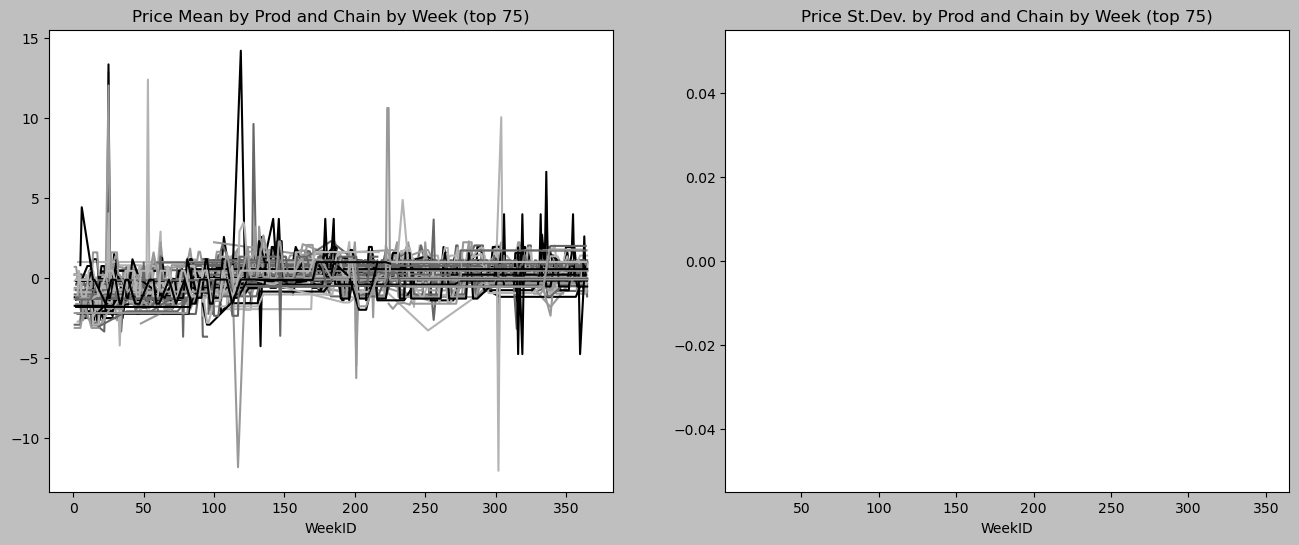

ProductCustomer  WeekID  Price9LMean  \
8613      TAAKA VODKA 80 BLUE PET 375M-THE BARREL HOUSE     119    14.212836   
6442   MCCORMICK CHERRY VODKA 60  1L-WESTERN BEV LIQ TX      25    13.359039   
6145    MCCORMICK APPLE VODKA 60  1L-WESTERN BEV LIQ TX      25    12.881215   
6957  MCCORMICK WATERMELON VODKA 60  1L-WESTERN BEV ...      53    12.405947   
6783    MCCORMICK PEACH VODKA 60  1L-WESTERN BEV LIQ TX      25    12.039242   
...                                                 ...     ...          ...   
773                   GENTLEMAN JACK WHSKY 6PK 1L-SPECS     201    -5.476514   
2310                   JACK DANIELS BLK WHSKY  1L-SPECS     201    -6.262245   
2403                   JACK DANIELS BLK WHSKY  1L-SPECS     302    -7.928517   
8234      TAAKA VODKA 80 BLUE PET 200M-THE BARREL HOUSE     117   -11.838695   
3969               JACK DANIELS BLK WHSKY LSE 50M-SPECS     302   -12.055152   

      Price9LStd  ProductID  CustomerID  
8613         NaN     854495        1577  
6442         NaN      82970        1624  
6145         NaN      82976        1624  
6957         NaN      83007        1624  
6783         NaN      82973        1624  
...          ...        ...         ...  
773          NaN       6032     1000325  
2310         NaN       5413     1000325  
2403         NaN       5413     1000325  
8234         NaN     854516        1577  
3969         NaN       5410     1000325  

[10716 rows x 6 columns]

In [21]:
# center and scale price per each product

dataT = data[data['Dollar Sales per 9L Case'] > 0].copy()
dataT['ProductCustomer'] = dataT['Product'] +'-' + dataT['Chain Master']
dataT['Dollar Sales per 9L Case Norm'] = dataT.groupby('ProductCustomer')['Dollar Sales per 9L Case'].transform(lambda x:(x - x.mean()) / x.std())

topNum=75
topProds = (dataT.groupby('ProductCustomer')
            .agg(Tot9LCases= ('9L Cases',sum))
            .sort_values(by='Tot9LCases',ascending=False)
            .head(topNum)
           )

productsWeek=(dataT[dataT['ProductCustomer'].isin(topProds.index.values)]
               .groupby(['ProductCustomer','WeekID'])
               .agg(Price9LMean=('Dollar Sales per 9L Case Norm',np.mean)
                    ,Price9LStd=('Dollar Sales per 9L Case Norm',np.std)
                    ,ProductID=('Product ID','first')
                    ,CustomerID=('Chain Master ID','first')
                   )               
               .reset_index()
               )

plt.style.use('grayscale')
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
productsWeek.groupby('ProductCustomer').plot.line(x='WeekID',y='Price9LMean',ax=ax1)
ax1.get_legend().remove()
ax1.set_title("Price Mean by Prod and Chain by Week (top " + str(topNum) + ')')

productsWeek.groupby('ProductCustomer').plot.line(x='WeekID',y='Price9LStd',ax=ax2)
ax2.get_legend().remove()
ax2.set_title("Price St.Dev. by Prod and Chain by Week (top " + str(topNum) + ')')
ax2.set_xlim( productsWeek['WeekID'].min(),productsWeek['WeekID'].max())
plt.show()
#print(productsMonth.shape)
productsWeek.sort_values(by='Price9LMean',ascending=False)


### Bottom Chain ID and Products

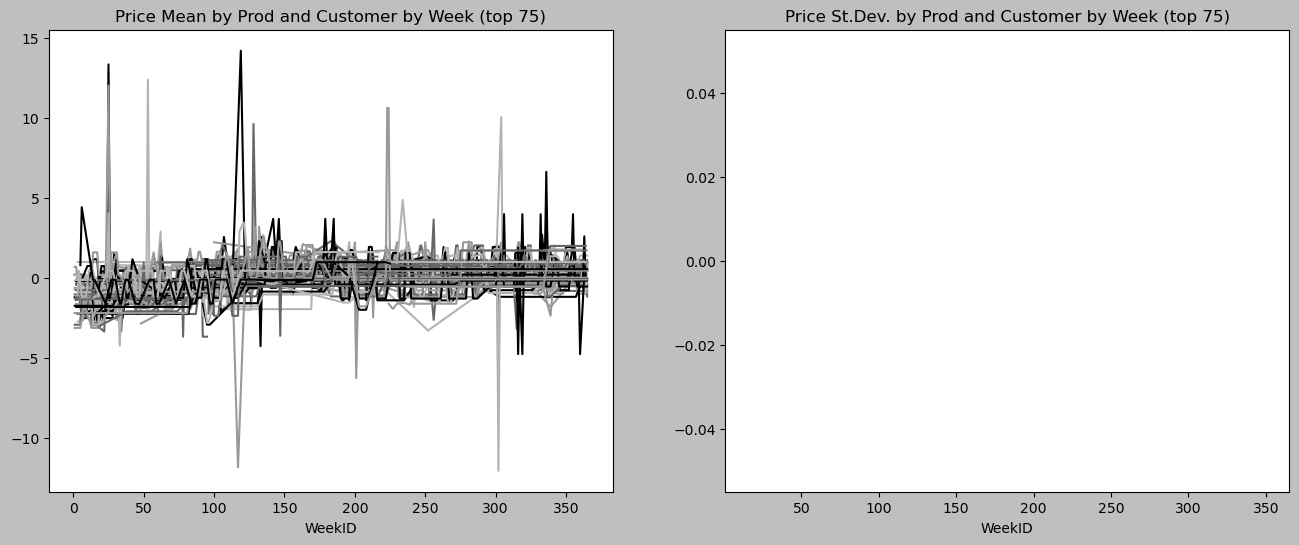

In [22]:
# center and scale price per each product
dataT = data[data['Dollar Sales per 9L Case'] > 0].copy()
dataT['ProductCustomer'] = dataT['Product'] +'-' + dataT['Chain Master']
dataT['Dollar Sales per 9L Case Norm'] = dataT.groupby('ProductCustomer')['Dollar Sales per 9L Case'].transform(lambda x:(x - x.mean()) / x.std())

topNum=75
bottomProds = (dataT.groupby('ProductCustomer')
            .agg(Tot9LCases= ('9L Cases',sum))
            .sort_values(by='Tot9LCases',ascending=False)
            .head(topNum)
           )

productsMonth=(dataT[dataT['ProductCustomer'].isin(bottomProds.index.values)]
               .groupby(['ProductCustomer','WeekID'])
               .agg(Price9LMean=('Dollar Sales per 9L Case Norm',np.mean)
                    ,Price9LStd=('Dollar Sales per 9L Case Norm',np.std)
                    ,ProductID=('Product ID','first')
                    ,CustomerID=('Chain Master ID','first')
                   )               
               .reset_index()
               )

plt.style.use('grayscale')
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
productsMonth.groupby('ProductCustomer').plot.line(x='WeekID',y='Price9LMean',ax=ax1)
ax1.get_legend().remove()
ax1.set_title("Price Mean by Prod and Customer by Week (top " + str(topNum) + ')')

productsMonth.groupby('ProductCustomer').plot.line(x='WeekID',y='Price9LStd',ax=ax2)
ax2.get_legend().remove()
ax2.set_title("Price St.Dev. by Prod and Customer by Week (top " + str(topNum) + ')')
ax2.set_xlim( productsMonth['WeekID'].min(),productsMonth['WeekID'].max())
plt.show()
#print(productsMonth.shape)
productsMonth.sort_values(by='Price9LMean',ascending=False)
plt.style.use('default')

## Contribution to the revenue

Product  Product ID  ratioRevenue  \
0                  JACK DANIELS BLK WHSKY  1L           0      0.351408   
1               JACK DANIELS BLK WHSKY  1.75L           1      0.152885   
2                JACK DANIELS BLK WHSKY  750M           2      0.082597   
3  JACK DANIELS BLK WHSKY 3PK W/2L COKE 1.75L           3      0.029485   
4           JACK DANIELS TENN HNY WHSKY  750M           4      0.029419   
5                GENTLEMAN JACK WHSKY OL 750M           5      0.029368   

   Running Ratio Revenue  
0               0.351408  
1               0.504293  
2               0.586890  
3               0.616375  
4               0.645795  
5               0.675163

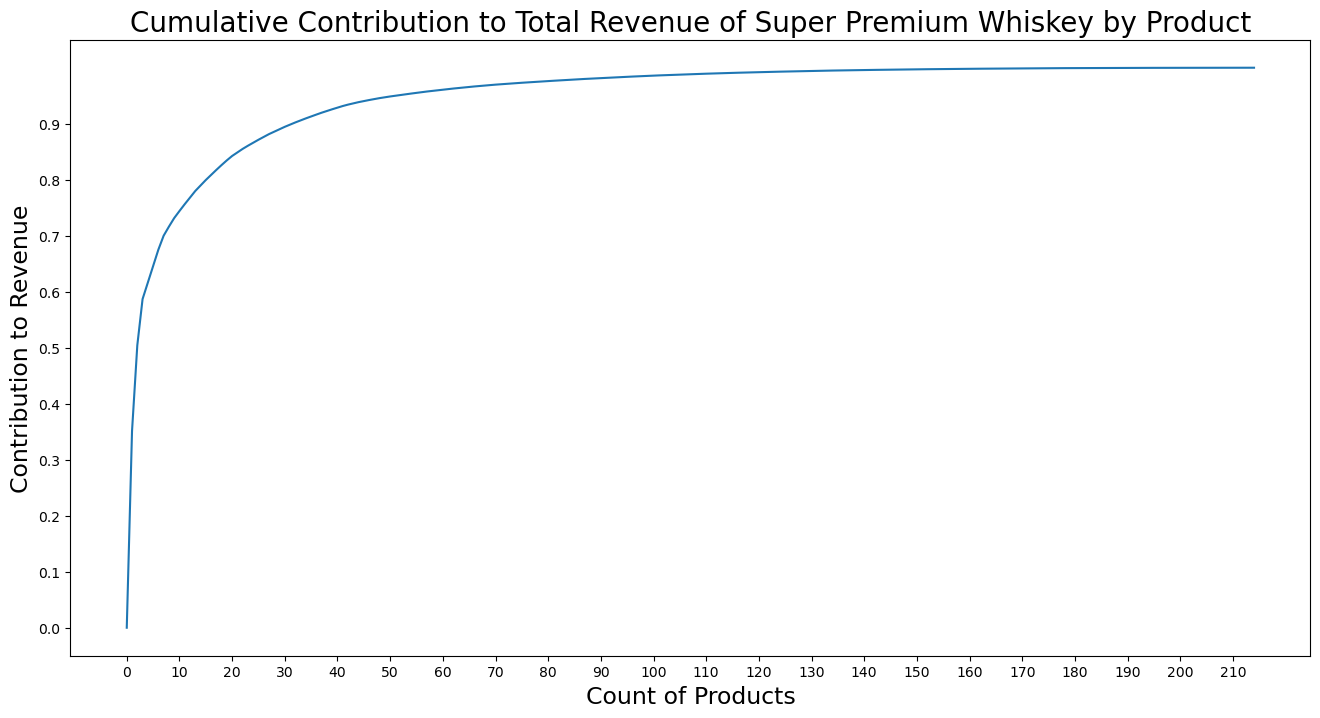

In [23]:
#for Superpium
#all chain
#highest revenue first

t=(data[data['Category (CatMan)']=='SUP PREM WHISKEY']
   .groupby(['Product'])
   .agg(WeeksCount=('WeekID','nunique')
        ,DollarSales = ('Dollar Sales',np.sum)
       )
  )
t['ratioRevenue'] = t['DollarSales'] / sum(t['DollarSales'])
#t=t.append(pd.DataFrame([[0,0,0]],columns=t.columns))
t=t.sort_values(['DollarSales'],ascending=False)

runningSalesByCount=t['ratioRevenue'].cumsum()
t['Running Ratio Revenue'] = runningSalesByCount
runningSalesByCount=pd.Series(0).append(runningSalesByCount)
#runningSalesByCountPerc = runningSalesByCount / sum(t['DollarSales'])
plt.figure(figsize=(16,8))
y=runningSalesByCount
x=np.arange(len(runningSalesByCount))
plt.plot(x,y)
plt.xticks(np.arange(min(x), max(x)+1, 10.0))
plt.yticks(np.arange(0, 1, 0.1))
plt.xlabel("Count of Products",fontsize=17)
plt.ylabel("Contribution to Revenue",fontsize=17)
plt.title("Cumulative Contribution to Total Revenue of Super Premium Whiskey by Product",fontsize=20)
t['Product ID']=np.arange(t.shape[0])
t=t.reset_index()
display(t[t['Running Ratio Revenue']<=0.7][['Product','Product ID','ratioRevenue','Running Ratio Revenue']])
#runningSalesByCount.plot()

### By Product

Count of transaction per product vs thier contribution to the Revenue

<AxesSubplot:xlabel='Count'>

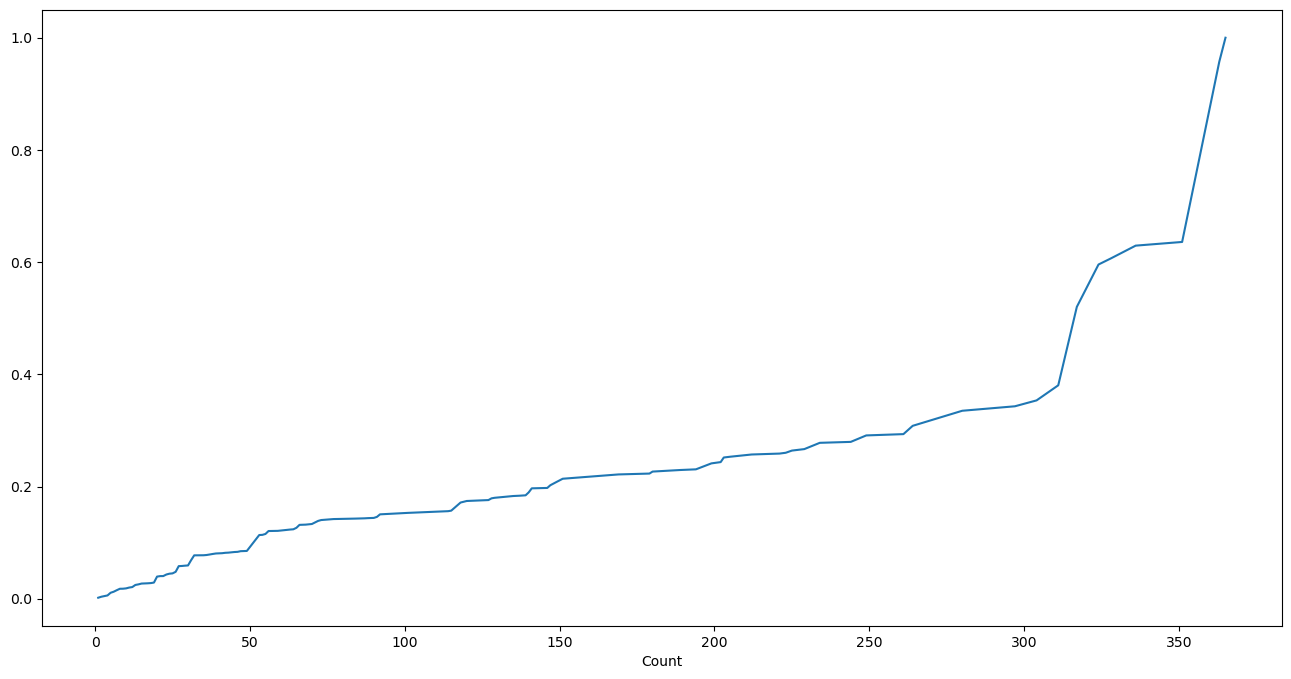

In [24]:
#for Superpium
#all chain
#highest revenue first

t=(data.groupby(['Product'])
   .agg(Count=('WeekID','nunique')
        ,DollarSales = ('Dollar Sales',np.sum)
       )
  )
t['ratioRevenue'] = t['DollarSales'] / sum(t['DollarSales'])
runningSalesByCount=t.groupby('Count')['DollarSales'].sum().cumsum()
runningSalesByCountPerc = runningSalesByCount / sum(t['DollarSales'])
plt.figure(figsize=(16,8))
runningSalesByCountPerc.plot()

### By Product  and Customer Chain

Count of transaction per product and Customer Chain vs thier contribution to the Revenue

<AxesSubplot:xlabel='Count'>

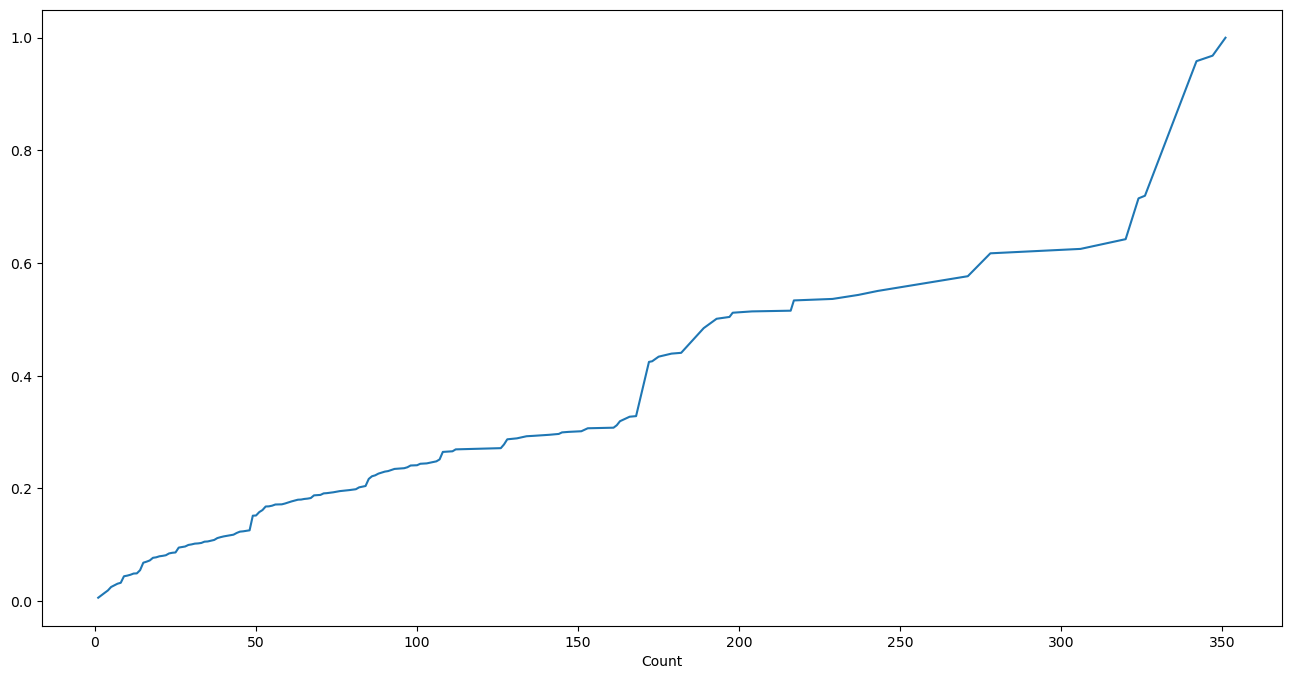

In [25]:


t=(data.groupby(['Product','Chain Master'])
   .agg(Count=('WeekID','nunique')
        ,DollarSales = ('Dollar Sales',np.sum)
       )
  )
t['ratioRevenue'] = t['DollarSales'] / sum(t['DollarSales'])
runningSalesByCount=t.groupby('Count')['DollarSales'].sum().cumsum()
runningSalesByCountPerc = runningSalesByCount / sum(t['DollarSales'])
plt.figure(figsize=(16,8))
runningSalesByCountPerc.plot()


# Price Elasticity

Calculated for Top Products per each Customer Chain

In [27]:
customers = data.groupby(['Chain Master'])['9L Cases'].agg(sum='sum').sort_values(by='sum',ascending=False)
products = data.groupby(['Product'])['9L Cases'].agg(sum='sum').sort_values(by='sum',ascending=False)
print(customers.head(5))
print(products.head(5))

                          sum
Chain Master                 
WESTERN BEV LIQ TX  49431.774
SPECS               48765.017
THE BARREL HOUSE     9015.350
                                     sum
Product                                 
JACK DANIELS BLK WHSKY  1L     24875.880
TAAKA VODKA 80  1L             16768.643
JACK DANIELS BLK WHSKY  1.75L  13379.730
JACK DANIELS BLK WHSKY  750M    6001.000
TAAKA VODKA 80 BLUE PET 375M    3096.667


C:\Users\annam\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


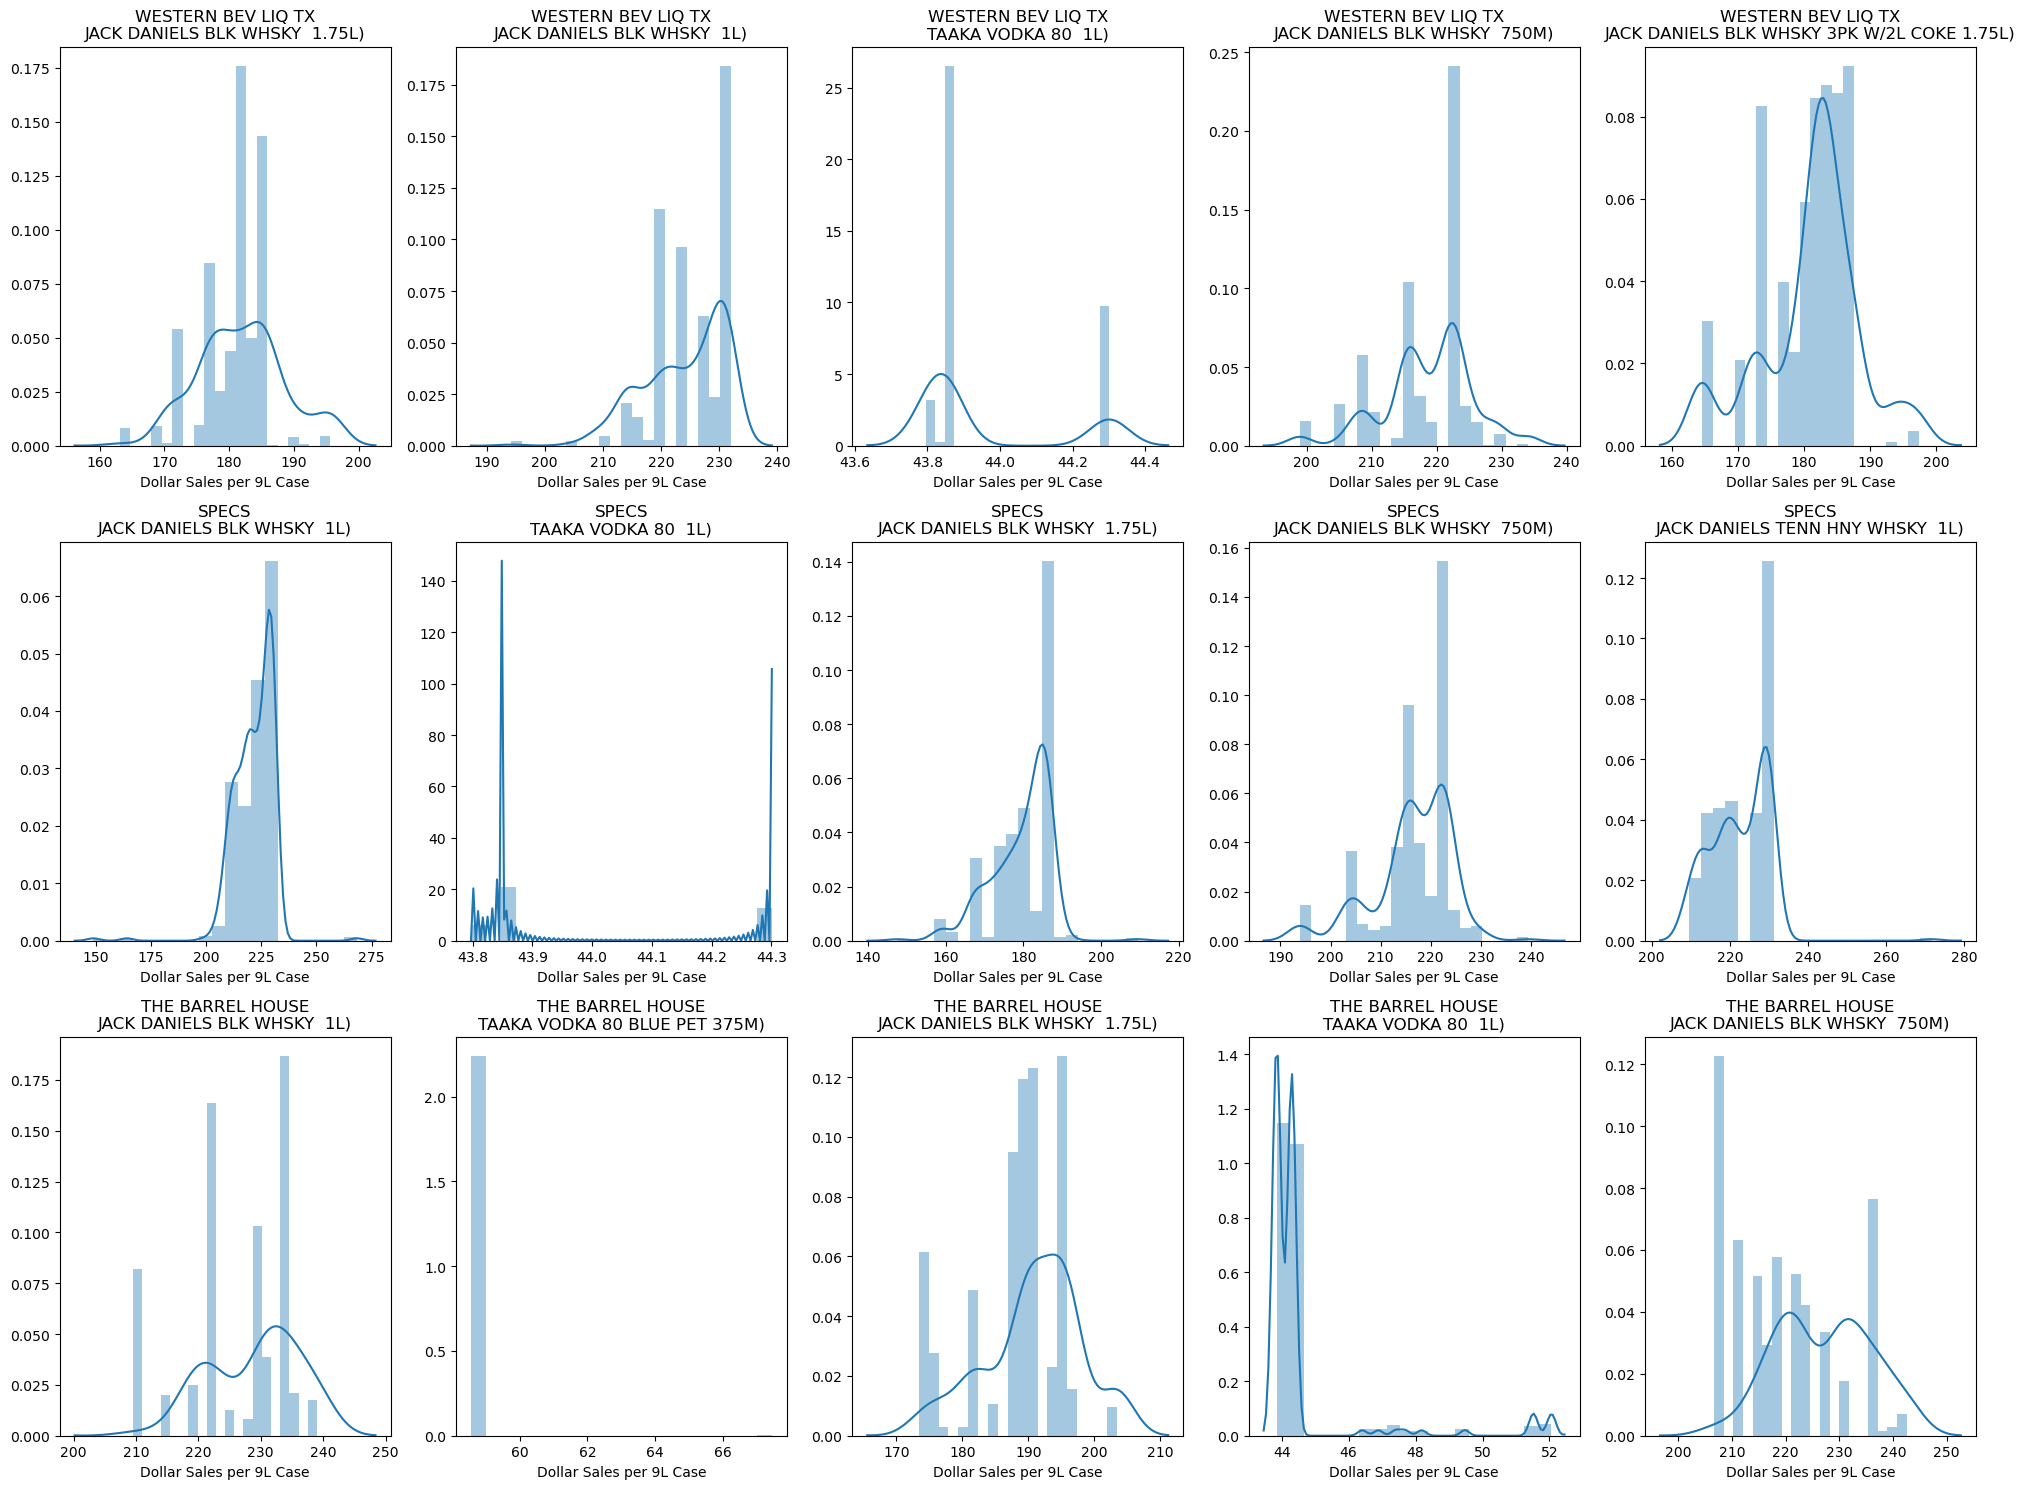

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
cs = 3
ps = 5
cust=customers.index[0:cs]
#prod=products.index[0:ps]
fig, axs = plt.subplots(cs,ps,figsize=(ps*4,5*cs))
for ic,c in enumerate(cust):
    CustProducts = data[data['Chain Master']==c].groupby(['Product'])['9L Cases'].agg(sum='sum').sort_values(by='sum',ascending=False).index[0:ps]
    for ip,p in enumerate(CustProducts):
        t=data[(data['Chain Master']==c)  &  (data['Product']==p)]
        sns.distplot(t['Dollar Sales per 9L Case'], hist_kws={'weights':t['Dollar Sales']},bins=20,ax=axs[ic,ip]).set_title(c + "\n" + p+')')
        #sns.distplot(t['Dollar Sales per 9L Case'], hist_kws={'weights':t['9L Cases']},bins=20,ax=axs[ic,ip],color='green',hist=False)
plt.tight_layout()


# Time Series 

In [41]:
import os
import glob
import sys
import math
from typing import List, Optional
from functools import partial
import itertools
import copy


In [42]:
sys.path.append(os.environ['DEV_AUTOTS'])
sys.path.append(os.environ['CAPSTONE_PYTHON_SOURCE'])
folder = os.environ['CAPSTONE_DATA']
from ETL.ETL import loadDataset, getTopProducts
from similarity.similarity import mergeTopSimilar, loadSimilarity
from charting.charting import surface3DChart


In [35]:
#Parameters
ChainMaster = 'SPECS'
ProdCat='SUP PREM WHISKEY'
TOP_PRODUCTS = 3  # How many products to consider in the category
TOP_SIMILAR = 1  # Get TOP_SIMILAR most similar products

LOG_TRANSFORM = True # Take log of 9L cases to smooth out peaks and valleys
ZERO_ADDER = 0.1 

RESAMPLE_FREQ = 'M'

# Pricing changes every 4 weeks
if RESAMPLE_FREQ == 'M':
    FORECAST_PERIOD = 1
if RESAMPLE_FREQ == 'W':
    FORECAST_PERIOD = 4 
if RESAMPLE_FREQ == '2W':
    FORECAST_PERIOD = 2 

# Seasonal Period
if RESAMPLE_FREQ == 'M':
    SEASONAL_PERIOD = 12  # Yearly
if RESAMPLE_FREQ == 'W':
    SEASONAL_PERIOD = 13 # Quarterly (we can also take yearly = 52, but SARIMAX becomes too slow)
if RESAMPLE_FREQ == '2W':
    SEASONAL_PERIOD = 13 # This becomes problematic --> for quarterly, should we take 6 biweekly periods or 7 bi-weekly periods. Instead I just took half yearly period  

print("="*50)
print("Parameters being used...")
print("="*50)
print(f"Resample Frequency = {RESAMPLE_FREQ}")
print(f"Forecast Period = {FORECAST_PERIOD}")
print(f"Seasonal Period = {SEASONAL_PERIOD}")
print(f"Chain: {ChainMaster}")
print(f"Product Category: {ProdCat}")



Parameters being used...
Resample Frequency = M
Forecast Period = 1
Seasonal Period = 12
Chain: SPECS
Product Category: SUP PREM WHISKEY


In [38]:
dataRaw= loadDataset(version=4)
dfSimilarity = loadSimilarity(version=4)
ProductsList = getTopProducts(dataRaw, ChainMaster=ChainMaster, ProdCat=ProdCat, topN=TOP_PRODUCTS, timeCol='WeekDate')
ProductsList

['JACK DANIELS BLK WHSKY  1L',
 'JACK DANIELS BLK WHSKY  1.75L',
 'JACK DANIELS BLK WHSKY  750M']

## Price vs. Demand

resampling to  M
Decoder: {'0': 'JACK DANIELS BLK WHSKY  1L', '1': 'JACK DANIELS BLK WHSKY  1.75L', '2': 'JACK DANIELS BLK WHSKY  750M'}



--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  1L
--------------------------------------------------
Exogenous Price Columns: ['0', '1']
% of weeks without a purchase: 0.0


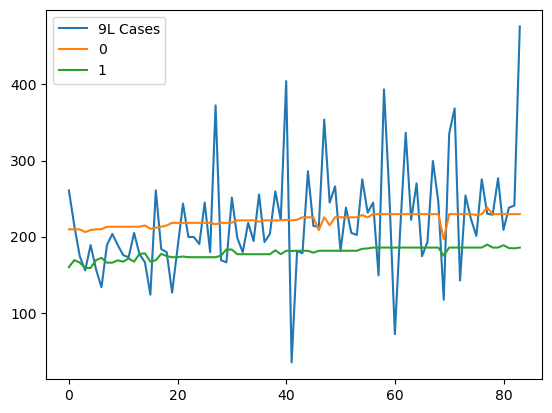

resampling to  M



--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  1.75L
--------------------------------------------------
Exogenous Price Columns: ['1', '0']
% of weeks without a purchase: 8.333333333333332


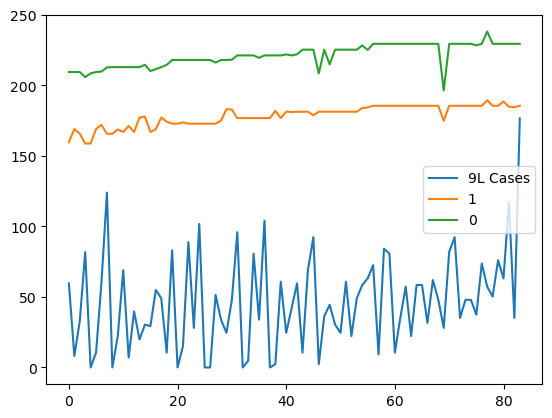

resampling to  M



--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  750M
--------------------------------------------------
Exogenous Price Columns: ['2', '0']
% of weeks without a purchase: 2.380952380952381


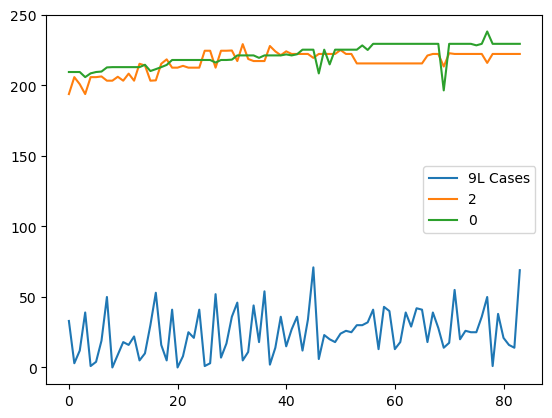

In [39]:
all_data = []

colTime = 'WeekDate'
colPreds = ['9L Cases'] #Demand
colPrice = ['Dollar Sales per 9L Case'] #Price

for i, Product in enumerate(ProductsList):
    # Product = ProductsList[0]
    # colTime = 'WeekDate'
    # colPreds = ['9L Cases'] #Demand
    # colPrice = ['Dollar Sales per 9L Case'] #Price

    #TO DO:
    #Merge top similar only looking at a list of products  DONE
    #Encode before the merge? (same prods same code) DONE
    #one chain, top three products, top 1 similar DONE
    #Impute the price DONE
    (dataModel,colExog,colEnc,colDec) = mergeTopSimilar(dataRaw, dfSimilarity
                                                        ,ChainMaster=ChainMaster
                                                        ,Product=Product
                                                        ,ProductsList=ProductsList
                                                        ,topn=TOP_SIMILAR 
                                                        ,periodCol = colTime
                                                        ,resampleFreq=RESAMPLE_FREQ
                                                        ,encodeCols=True)
                                                                            
    
    if i == 0:
        print(f"Decoder: {colDec}")

    print("\n\n")
    print("-"*50)
    print(f"Product: {colDec.get(str(i))}")
    print("-"*50)
    
    #colExog = colExog + colEndog
    print(f"Exogenous Price Columns: {colExog}")
    
    allCols=[colTime]+colPreds+ colExog
    data=dataModel[allCols]
    print(f"% of weeks without a purchase: {sum(data['9L Cases'] == 0)/data.shape[0]*100}")
    # print(data.tail(5))
    data.iloc[:][data.columns[-(TOP_SIMILAR+2):]].plot()
    all_data.append(data)
    plt.show()

## Log Transf for Demand




--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  1L
--------------------------------------------------


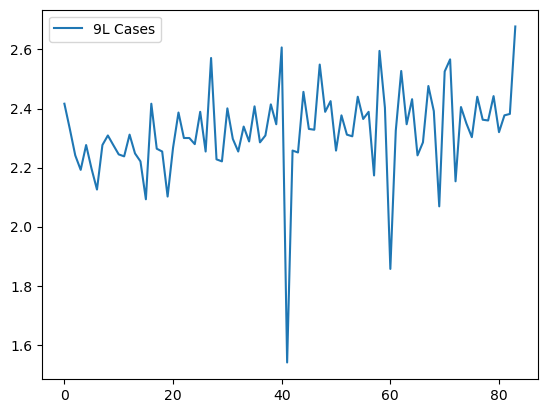




--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  1.75L
--------------------------------------------------


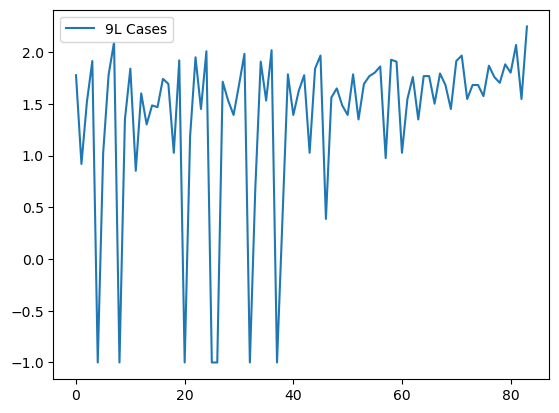




--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  750M
--------------------------------------------------


C:\Users\annam\Anaconda3\lib\site-packages\pandas\core\frame.py:3062: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



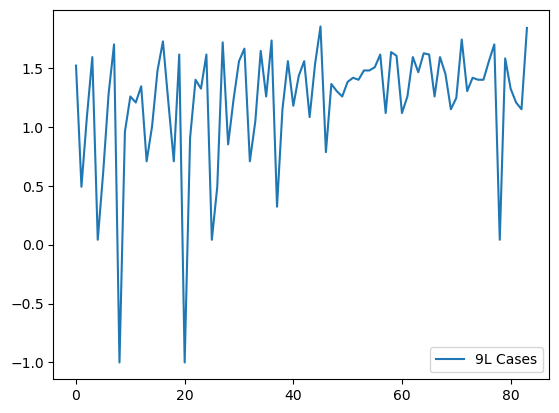

In [43]:
# Input Transformation

all_data_non_transformed =  copy.deepcopy(all_data)
    
if LOG_TRANSFORM: 
    for i in np.arange(len(all_data)):
        all_data_non_transformed[i] = all_data[i].copy(deep=True)
        all_data[i][colPreds] = np.log10(all_data[i][colPreds] + ZERO_ADDER)
        print("\n\n")
        print("-"*50)
        print(f"Product: {colDec.get(str(i))}")
        print("-"*50)
        
        all_data[i].iloc[:][colPreds].plot()
        plt.show()    

## Test for White Noise

In [45]:
import statsmodels.api as sm
white_noise_all = []
white_noise_df_all = []

for i, data in enumerate(all_data):
    print("\n\n")
    print("-"*50)
    print(f"Product: {colDec.get(str(i))}")
    print("-"*50)
    white_noise_df = sm.stats.acorr_ljungbox(data[colPreds], lags=[24, 48], return_df=True)
    white_noise_df_all.append(white_noise_df)
    if any(white_noise_df['lb_pvalue'] > 0.05):
        white_noise = True
    else:
        white_noise = False
    white_noise_all.append(white_noise)
    
    print(white_noise_df)
    print(f"\nIs Data White Noise: {white_noise}")





--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  1L
--------------------------------------------------
      lb_stat  lb_pvalue
24  26.538512   0.326419
48  48.667832   0.445959

Is Data White Noise: True



--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  1.75L
--------------------------------------------------
      lb_stat  lb_pvalue
24  41.411630   0.015005
48  54.239869   0.248702

Is Data White Noise: True



--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  750M
--------------------------------------------------
      lb_stat  lb_pvalue
24  38.221972    0.03290
48  54.395929    0.24408

Is Data White Noise: True


## Correlation Plots

In [ ]:
for i, data in enumerate(all_data):
    print("\n\n")
    print("-"*50)
    print(f"Product: {colDec.get(str(i))}")
    print("-"*50)

    # ACF and PACF Analysis
    # https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    _ = plot_acf(all_data[i]['9L Cases'], lags=50, ax=axes[0], title=f"ACF | Product: {colDec.get(str(i))}")
    _ = plot_pacf(all_data[i]['9L Cases'], lags=36, ax=axes[1], title=f"PACF | Product: {colDec.get(str(i))}")
    
    # CCF Analysis
    # https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/xcorr_acorr_demo.html#sphx-glr-gallery-lines-bars-and-markers-xcorr-acorr-demo-py
    cols = all_data[i].columns
    fig, axes = plt.subplots(1, 3, figsize=(18,4))
    axes[0].xcorr(all_data[i]['9L Cases'], all_data[i][cols[-1]]) # Demand vs. Sim Product Price
    axes[0].set_title('CCF | Demand vs. Sim Product Price')
    axes[1].xcorr(all_data[i]['9L Cases'], all_data[i][cols[-2]]) # Demand vs. Same Product Price
    axes[1].set_title('CCF | Demand vs. Same Product Price')
    axes[2].xcorr(all_data[i][cols[-2]], all_data[i][cols[-1]]) # Same vs. Sim Product Price
    axes[2].set_title('CCF | Same vs. Sim Product Price')

    # Spectral Density
    # https://scipy-lectures.org/intro/scipy/auto_examples/plot_spectrogram.html
    freqs, psd = signal.welch(all_data[i]['9L Cases'])
    plt.figure(figsize=(8, 4))
    plt.semilogy(freqs, psd)
    plt.title(f'Power Spectral Density | Product: {colDec.get(str(i))}')
    plt.xlabel('Frequency')
    plt.ylabel('Power')
      
    
    plt.tight_layout()
    plt.show()